In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
#Setting the figure style
plt.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 11,
    "figure.facecolor": "white",
})
C_AD = "#D64045"       
C_CONTENT = "#1B998B"  
C_ACCENT = "#2E4057"   

In [4]:
#1.: Data Preparation
data = pd.read_excel("eeg_segment_clean.xlsx")
data = data.rename(columns={"is-ad": "is_ad", "is-recall": "is_recall", "ad_order": "ad_position"})
data[["is_ad", "ad_position"]] = data[["is_ad", "ad_position"]].fillna(0).astype(int)

Upper_alpha_channels = [
    "mean-psd_Alpha-upper_F7_v^2/Hz",
    "mean-psd_Alpha-upper_AF7_v^2/Hz",
    "mean-psd_Alpha-upper_Fp1_v^2/Hz",
    "mean-psd_Alpha-upper_Fpz_v^2/Hz",
    "mean-psd_Alpha-upper_Fp2_v^2/Hz",
    "mean-psd_Alpha-upper_AF8_v^2/Hz",
    "mean-psd_Alpha-upper_F8_v^2/Hz",
]
data["upper_alpha_frontal_mean"] = data[Upper_alpha_channels].mean(axis=1, skipna=True)

eps = 1e-15
data["ln_upper_alpha_frontal_mean"] = np.log(np.maximum(data["upper_alpha_frontal_mean"], eps))
data["log_duration"] = np.log10(data["duration"].clip(lower = 0.1))

n_ads_per_subject = (
    data[data["is_ad"] == 1].groupby("subject_id").size().reset_index(name= "n_ads")
)
subj_baseline = (
    data[data["is_ad"] == 0].groupby("subject_id")["ln_upper_alpha_frontal_mean"]
    .mean().reset_index(name = "baseline_ln_upper_alpha_frontal_mean")
)

data = data.merge(n_ads_per_subject, on= "subject_id", how = "left")
data = data.merge(subj_baseline, on= "subject_id", how = "left")

#Z scoring of number of ads
subj_unique = data[["subject_id", "n_ads"]].drop_duplicates()
n_ads_mean = subj_unique["n_ads"].mean()
n_ads_std = subj_unique["n_ads"].std(ddof=1)
data["n_ads_z"] = (data["n_ads"] - n_ads_mean) / n_ads_std

#Centering of ad position
df_ads = data[data["is_ad"]== 1].copy()
df_ads["ad_position_c"] = df_ads.groupby("subject_id")["ad_position"].transform(lambda x: x - x.mean())
df_ads = df_ads.dropna(subset= ["ln_upper_alpha_frontal_mean", "ad_position_c", "log_duration", "n_ads_z"])

#Centering/Z scoring check
print("Centering Test")
print(f"r(n_ads_z, ad_position_c) = {df_ads[['ad_position_c', 'n_ads_z']].corr().iloc[0,1]:.4f}")

Centering Test
r(n_ads_z, ad_position_c) = -0.0066


In [5]:
#2.: Descriptive Analysis
print("Descriptive Statistics")
print(f"Participants: {data['subject_id'].nunique()}")
print(f"Total observations: {len(data)}, Ad observations: {len(df_ads)}")
print(f"Ads per session: mean = {df_ads.groupby("subject_id"). size().mean():.1f},"
      f"range = {df_ads.groupby("subject_id").size().min()} - {df_ads.groupby("subject_id").size().max()}")
print(f"ln(Alpha) Content : {data[data['is_ad']==0]['ln_upper_alpha_frontal_mean'].mean():.4f}")
print(f"ln(Alpha) Ads:     {data[data['is_ad']==1]['ln_upper_alpha_frontal_mean'].mean():.4f}")
print(f"Duration: mean={df_ads['duration'].mean()/1000:.2f}s, "
      f"median={df_ads['duration'].median()/1000:.2f}s, SD={df_ads['duration'].std()/1000:.2f}s")

Descriptive Statistics
Participants: 84
Total observations: 1142, Ad observations: 522
Ads per session: mean = 6.2,range = 2 - 18
ln(Alpha) Content : -27.7512
ln(Alpha) Ads:     -27.6867
Duration: mean=5.77s, median=2.67s, SD=9.90s


In [6]:
#3.1: H1a: Mixed Model - Ads vs Content
print("\nH1a: ADS vs CONTENT")

df_h1 = data[["ln_upper_alpha_frontal_mean", "is_ad", "subject_id"]].dropna().reset_index(drop=True)

model_h1a = smf.mixedlm(
    "ln_upper_alpha_frontal_mean ~ is_ad",
    data= df_h1,
    groups = "subject_id",
    re_formula= "is_ad"
).fit(reml= True, method= "lbfgs")

print(model_h1a.summary())




H1a: ADS vs CONTENT
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ln_upper_alpha_frontal_mean
No. Observations: 1124    Method:             REML                       
No. Groups:       84      Scale:              0.3307                     
Min. group size:  5       Log-Likelihood:     -1146.3632                 
Max. group size:  37      Converged:          Yes                        
Mean group size:  13.4                                                   
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                 -27.772    0.129 -215.545 0.000 -28.024 -27.519
is_ad                       0.089    0.038    2.311 0.021   0.013   0.164
subject_id Var              1.343    0.393                               
subject_id x is_ad Cov     -0.045  

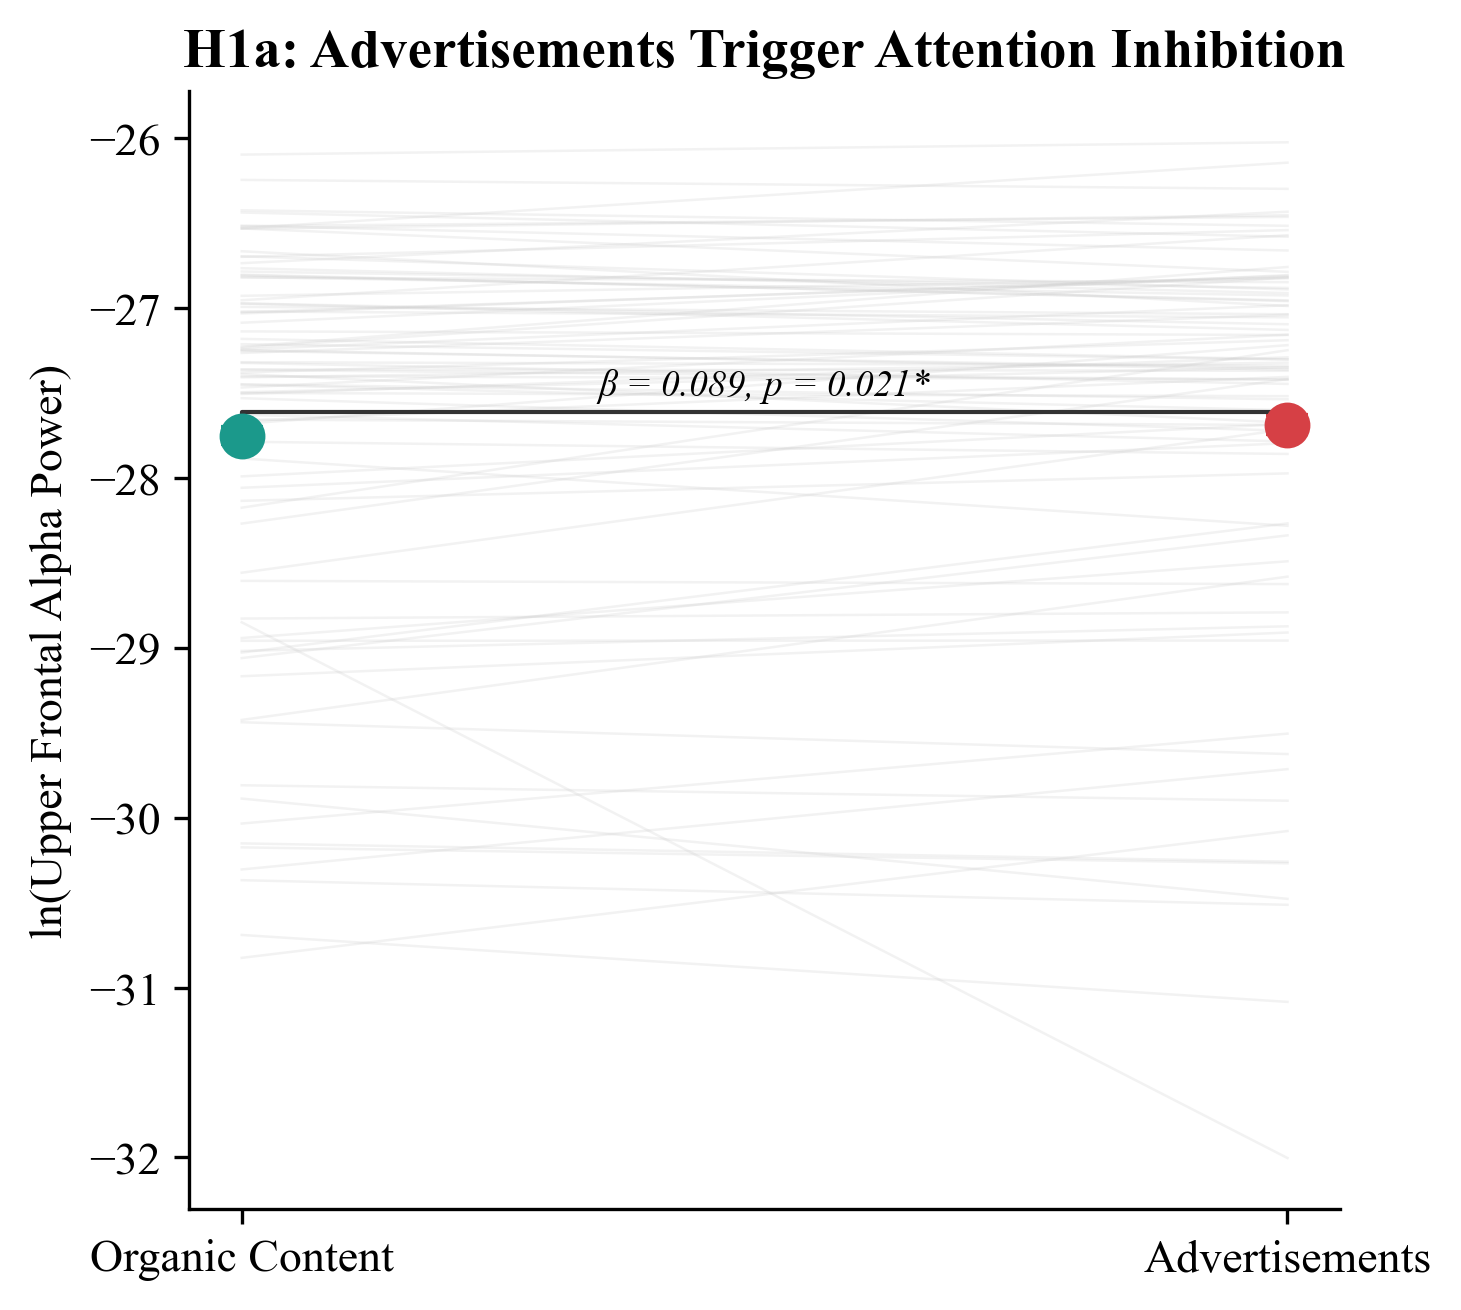

In [7]:
#3.2: FIGURE H1a : Compare alpha power between ads and content
fig, ax = plt.subplots(figsize=(5, 4.5))

# each participant's change from content to ad
subj_means = data.groupby(["subject_id", "is_ad"])["ln_upper_alpha_frontal_mean"].mean().unstack()
for _, row in subj_means.iterrows():
    ax.plot([0, 1], [row[0], row[1]], color="#CCCCCC", alpha=0.25, linewidth=0.6)

# group means with error bars
cm = data[data["is_ad"]==0]["ln_upper_alpha_frontal_mean"]
am = data[data["is_ad"]==1]["ln_upper_alpha_frontal_mean"]
ax.errorbar(0, cm.mean(), yerr=cm.sem(), fmt="o", color=C_CONTENT, markersize=10, capsize=5)
ax.errorbar(1, am.mean(), yerr=am.sem(), fmt="o", color=C_AD, markersize=10, capsize=5)

# significance bracket
yb = max(cm.mean(), am.mean()) + max(cm.sem(), am.sem()) + 0.02
ax.plot([0, 0, 1, 1], [yb-0.005, yb, yb, yb-0.005], color="#333", lw=1)
b = model_h1a.params["is_ad"]
pv = model_h1a.pvalues["is_ad"]
ax.text(0.5, yb+0.1, f"β = {b:.3f}, p = {pv:.3f}*", ha="center", fontsize=9, fontstyle="italic")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Organic Content", "Advertisements"])
ax.set_ylabel("ln(Upper Frontal Alpha Power)")
ax.set_title("H1a: Advertisements Trigger Attention Inhibition", fontweight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Figure_H1a.png", bbox_inches="tight")
plt.show()


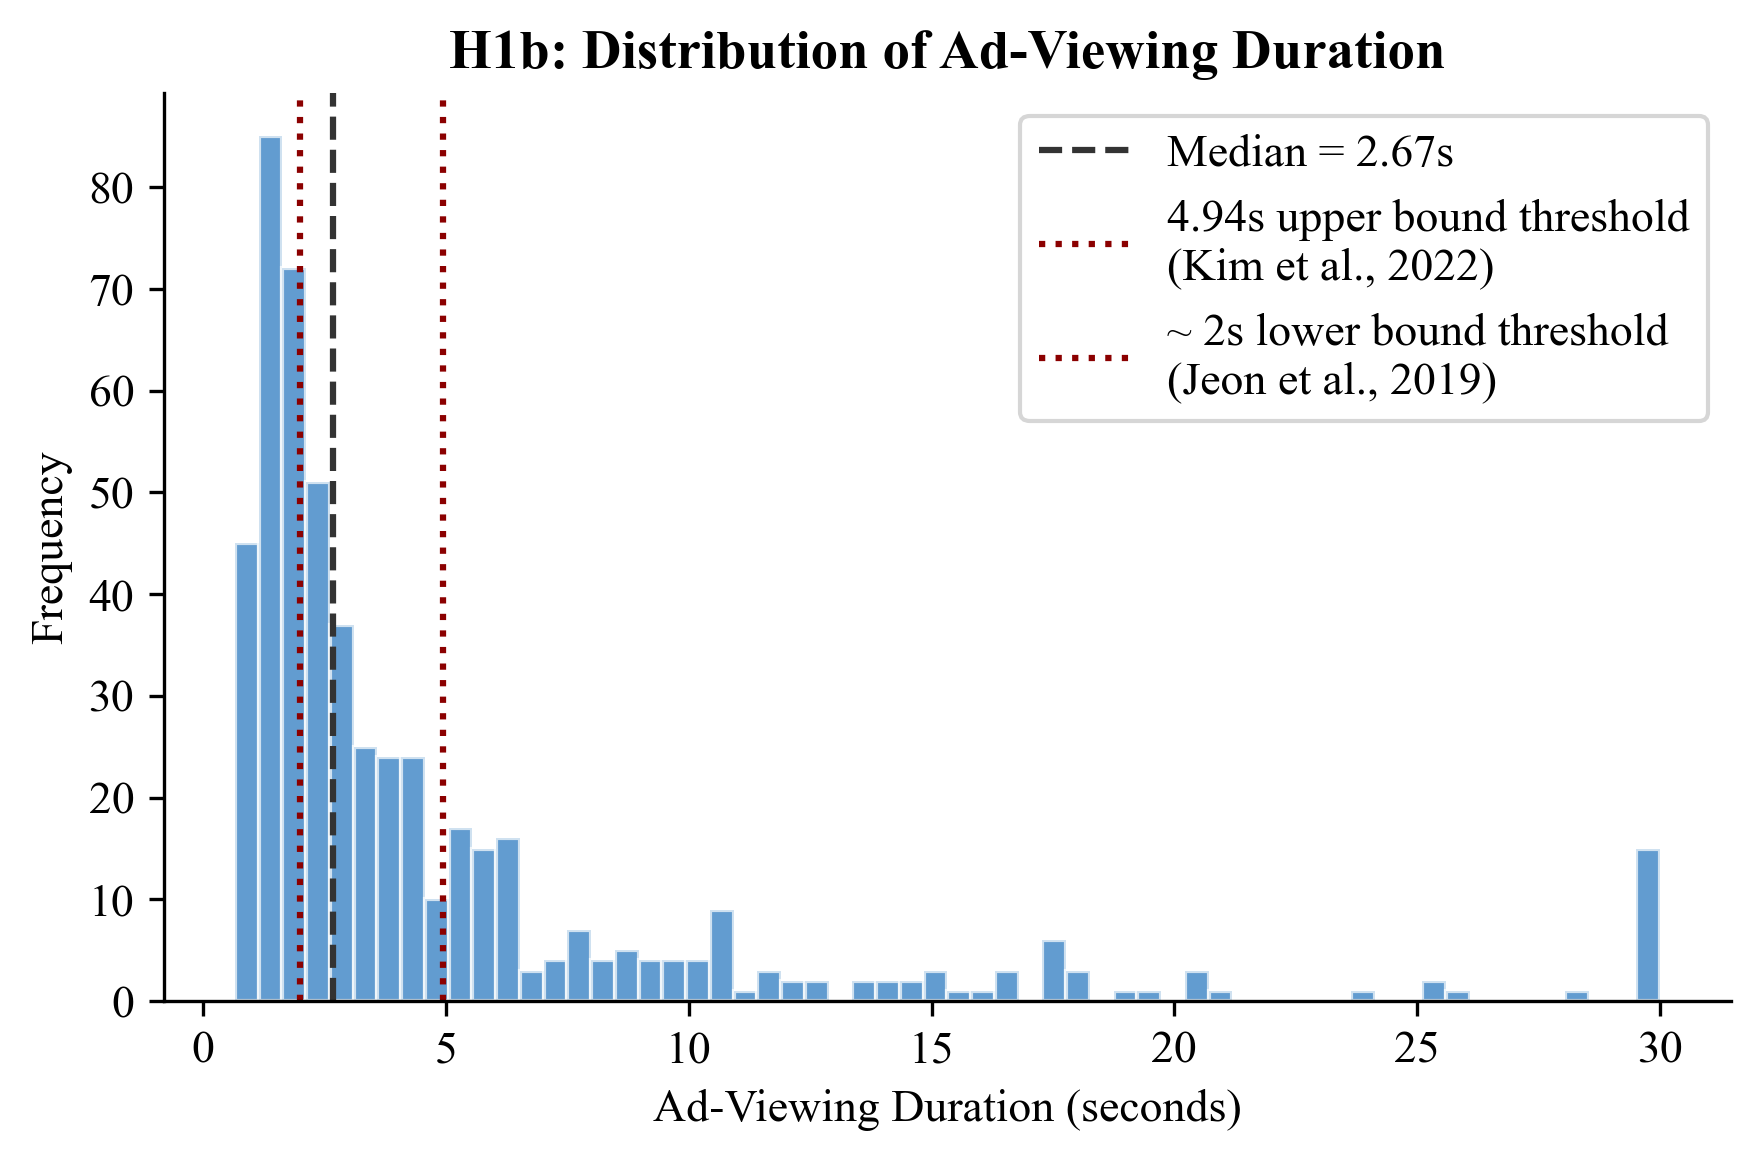

In [8]:
#4.: H1b: Mean Ad-Viewing Duration
fig, ax = plt.subplots(figsize=(6, 4))
dur_sec = df_ads["duration"] / 1000  # convert ms to seconds

ax.hist(dur_sec.clip(upper=30), bins=60, color= "#2073BC", alpha=0.7, edgecolor="white")
ax.axvline(dur_sec.median(), color="#333", ls="--", lw=1.5, label=f"Median = {dur_sec.median():.2f}s")
ax.axvline(4.94, color="#8B0000", ls=":", lw=1.5, label="4.94s upper bound threshold\n(Kim et al., 2022)")
ax.axvline(2, color= "#8B0000", ls=":", lw=1.5, label="~ 2s lower bound threshold\n(Jeon et al., 2019)")

ax.set_xlabel("Ad-Viewing Duration (seconds)")
ax.set_ylabel("Frequency")
ax.set_title("H1b: Distribution of Ad-Viewing Duration", fontweight="bold")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Figure_H1b.png", bbox_inches="tight")
plt.show()

In [9]:
#5.1.: H1c: relationship between cognitive and behavioral avoidance
def coef_with_ci(res, term, alpha=0.05):
    beta = res.params[term]
    pval = res.pvalues[term]
    lo, hi = res.conf_int(alpha=alpha).loc[term]
    return beta, pval, lo, hi

print("\nH1c Testing")
m_dur = smf.ols("log_duration ~ ln_upper_alpha_frontal_mean", data=df_ads).fit(
    cov_type="cluster", cov_kwds={"groups": df_ads["subject_id"]})
m_alp = smf.ols("ln_upper_alpha_frontal_mean ~ log_duration", data=df_ads).fit(
    cov_type="cluster", cov_kwds={"groups": df_ads["subject_id"]})
print(f"Duration ~ Alpha: β={m_dur.params['ln_upper_alpha_frontal_mean']:.3f}, p={m_dur.pvalues['ln_upper_alpha_frontal_mean']:.3f}")
print(f"Alpha ~ Duration: β={m_alp.params['log_duration']:.3f}, p={m_alp.pvalues['log_duration']:.3f}")
b, p, lo, hi = coef_with_ci(m_dur, "ln_upper_alpha_frontal_mean")
print(f"Duration ~ Alpha: β={b:.3f}, p={p:.3f}, 95% CI [{lo:.3f}, {hi:.3f}]")


H1c Testing
Duration ~ Alpha: β=-0.044, p=0.035
Alpha ~ Duration: β=-0.433, p=0.047
Duration ~ Alpha: β=-0.044, p=0.035, 95% CI [-0.085, -0.003]


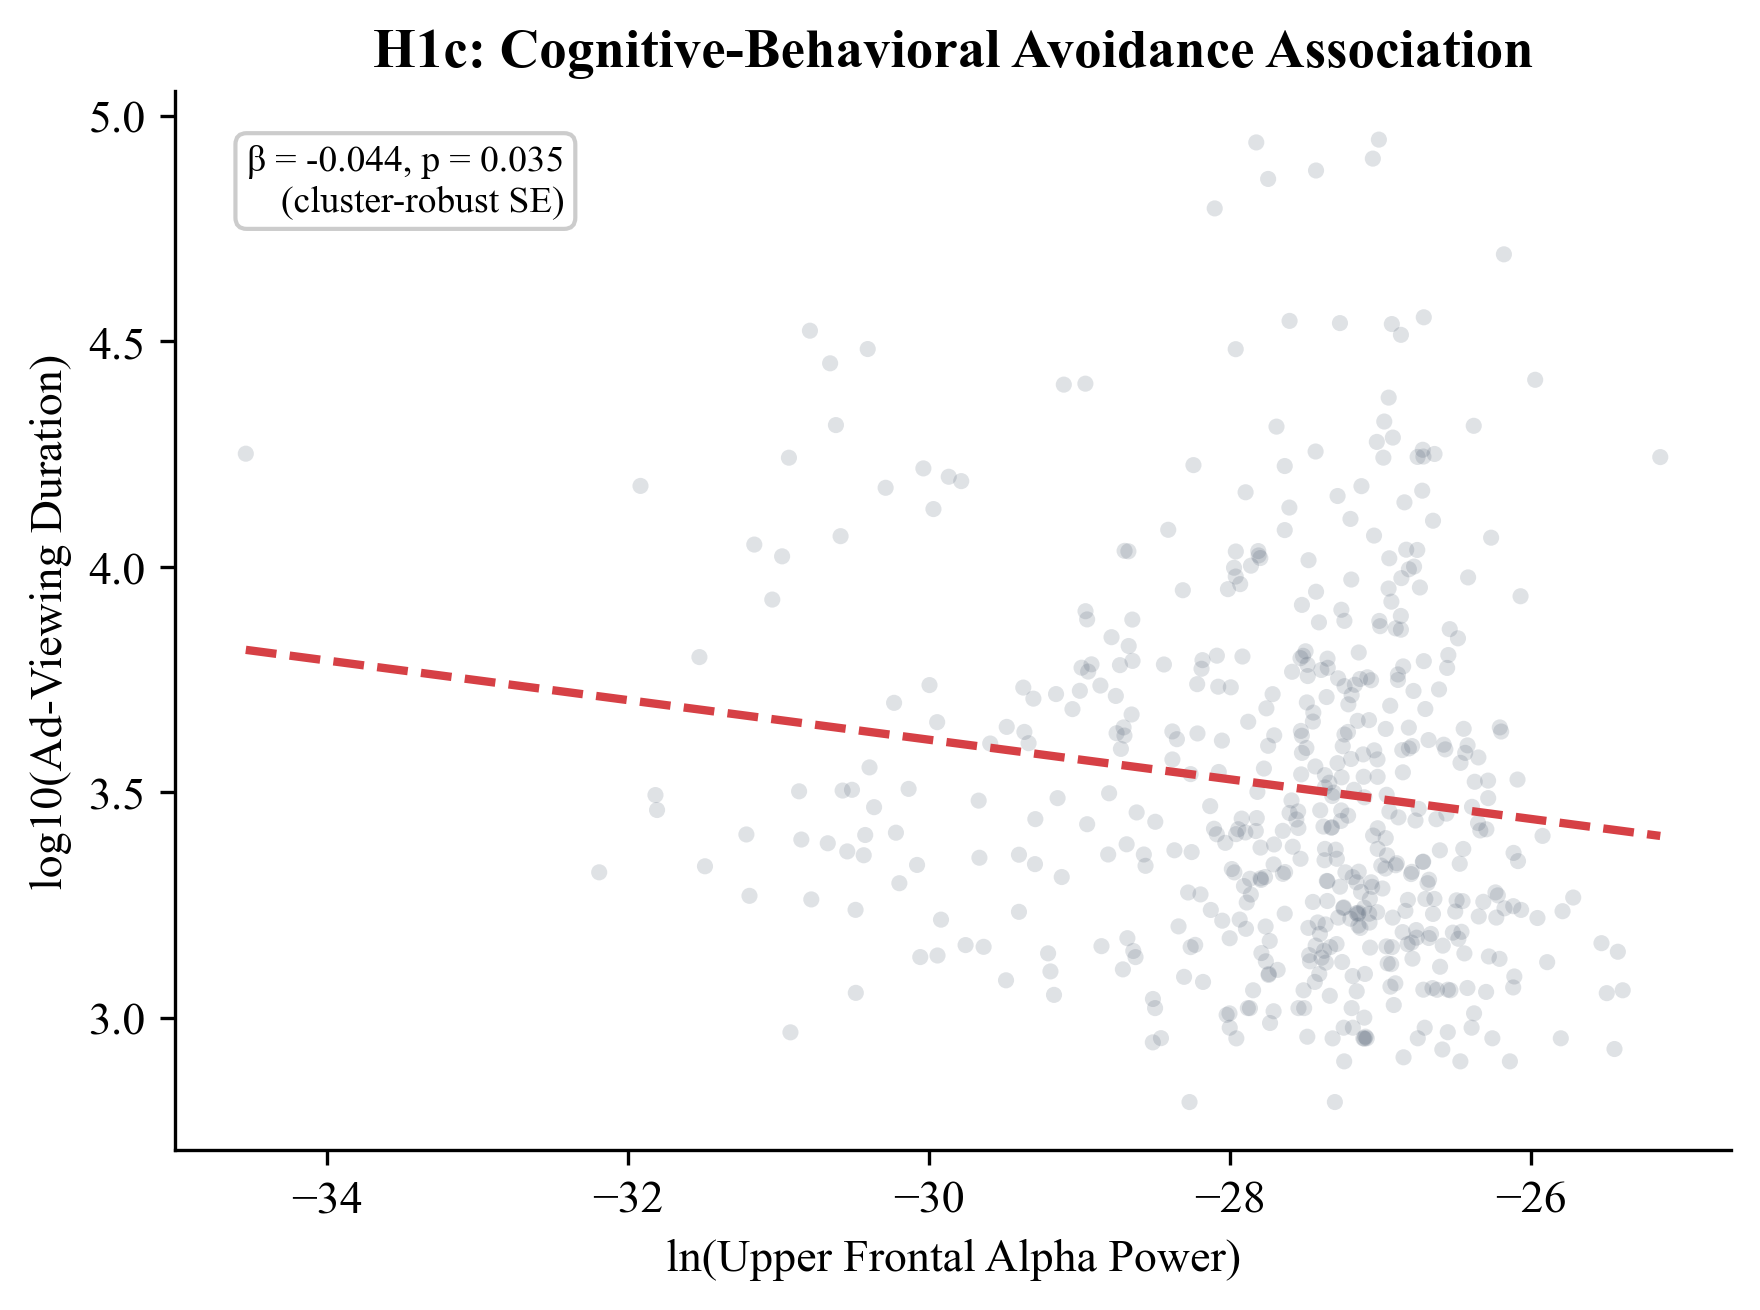

In [10]:
#5.2.: FIGURE H1c: Observation Level Scatter Plot
#Each dot represent one observation, the regression line represents the actual OLS model tested for H1c
fig, ax = plt.subplots(figsize=(6, 4.5))

ax.scatter(df_ads["ln_upper_alpha_frontal_mean"], df_ads["log_duration"],
           color=C_ACCENT, alpha=0.15, s=15, edgecolor="none")

beta0 = m_dur.params["Intercept"]
beta1 = m_dur.params["ln_upper_alpha_frontal_mean"]
xl = np.linspace(df_ads["ln_upper_alpha_frontal_mean"].min(),
                 df_ads["ln_upper_alpha_frontal_mean"].max(), 100)
ax.plot(xl, beta0 + beta1 * xl, color=C_AD, lw=2, ls="--")

ax.text(0.25, 0.95,
        f"β = {beta1:.3f}, p = {m_dur.pvalues['ln_upper_alpha_frontal_mean']:.3f}\n(cluster-robust SE)",
        transform=ax.transAxes, ha="right", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#CCC"))

ax.set_xlabel("ln(Upper Frontal Alpha Power)")
ax.set_ylabel("log10(Ad-Viewing Duration)")
ax.set_title("H1c: Cognitive-Behavioral Avoidance Association", fontweight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Figure_H1c_observation.png", bbox_inches="tight")
plt.show()

In [11]:
#6.: H2a & H2c : Clutter + Ad Position --> Cognitive Attention Inhibiton
print("\nH2a/H2c : Realtionship Between Ad-clutter & Ad-position with Cognitive Avoidance")
M1 = smf.mixedlm(
    "ln_upper_alpha_frontal_mean ~ n_ads_z * ad_position_c",
    data= df_ads,
    groups = "subject_id",

).fit(reml= True, method= "lbfgs")
print(M1.summary())

#Robustness check with OLS & WLS
M2 = smf.ols("ln_upper_alpha_frontal_mean ~ n_ads_z + ad_position_c", data= df_ads
             ).fit(cov_type = "cluster", cov_kwds = {"groups" : df_ads["subject_id"]})
print("\nOLS without interaction results")
print(M2.summary())

M3 = smf.ols("ln_upper_alpha_frontal_mean ~ n_ads_z * ad_position_c", data= df_ads
             ).fit(cov_type = "cluster", cov_kwds = {"groups" : df_ads["subject_id"]})
print("\nOLS with interaction results")
print(M3.summary())

df_ads["weight"] = 1 / df_ads["n_ads"]
M4 = smf.wls("ln_upper_alpha_frontal_mean ~  n_ads_z + ad_position_c",
    data=df_ads, weights=df_ads["weight"]
).fit(cov_type="cluster", cov_kwds={"groups": df_ads["subject_id"]})
print("\nWLS:")
print(M4.summary())


H2a/H2c : Realtionship Between Ad-clutter & Ad-position with Cognitive Avoidance
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ln_upper_alpha_frontal_mean
No. Observations: 522     Method:             REML                       
No. Groups:       84      Scale:              0.4799                     
Min. group size:  2       Log-Likelihood:     -675.1728                  
Max. group size:  18      Converged:          Yes                        
Mean group size:  6.2                                                    
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                 -27.699    0.132 -210.513 0.000 -27.957 -27.441
n_ads_z                     0.027    0.131    0.202 0.840  -0.231   0.284
ad_position_c               0.002    0.019    0.

In [12]:
#Checking the marginal and contional R squared of the Mixed model
var_fixed = M1.fittedvalues.var()
var_random = M1.cov_re.iloc[0, 0]
var_resid = M1.scale
#Marginal R² (fixed effects only)
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

#Conditional R² (fixed + random effects)
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R²:    {r2_marginal:.4f}")
print(f"Conditional R²: {r2_conditional:.4f}")

Marginal R²:    0.3691
Conditional R²: 0.8353


In [13]:
#7.1.: H2b/H2d: Clutter + Ad Position --> Behavioral Avoidance
print("\nH2b & H2d: Realtionship Between Ad-clutter & Ad-position with Behavioral Avoidance ")
model_behav = smf.mixedlm(
    "log_duration ~  n_ads_z * ad_position_c",
    data= df_ads,
    groups = "subject_id"
).fit(reml= True, method= "lbfgs")
print("Mixed Model:")
print(model_behav.summary())

#Robustness check with OLS & WLS
m_ols = smf.ols("log_duration ~  n_ads_z + ad_position_c", data= df_ads
                ).fit(cov_type= "cluster", cov_kwds= {"groups": df_ads["subject_id"]})
print("\nOLS for robustness check")
print(m_ols.summary())

m_wls = smf.wls("log_duration ~  n_ads_z + ad_position_c", data=df_ads, weights = df_ads["weight"]
                ).fit(cov_type= "cluster", cov_kwds= {"groups": df_ads["subject_id"]})
print("\nWLS for robustness check")
print(m_wls.summary())


H2b & H2d: Realtionship Between Ad-clutter & Ad-position with Behavioral Avoidance 
Mixed Model:
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   log_duration
No. Observations:    522       Method:               REML        
No. Groups:          84        Scale:                0.1008      
Min. group size:     2         Log-Likelihood:       -217.4137   
Max. group size:     18        Converged:            Yes         
Mean group size:     6.2                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              3.550    0.031 113.198 0.000  3.488  3.611
n_ads_z               -0.074    0.030  -2.420 0.016 -0.134 -0.014
ad_position_c         -0.018    0.009  -2.020 0.043 -0.035 -0.001
n_ads_z:ad_position_c  0.006    0.004   1.509 0.131 -0.002

In [14]:
#Checking the marginal and contional R squared of the Mixed model
var_fixed = model_behav.fittedvalues.var()
var_random = model_behav.cov_re.iloc[0, 0]
var_resid = model_behav.scale
# Marginal R² (fixed effects only)
r2_marginal = var_fixed / (var_fixed + var_random + var_resid)

# Conditional R² (fixed + random effects)
r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

print(f"Marginal R²:    {r2_marginal:.4f}")
print(f"Conditional R²: {r2_conditional:.4f}")

Marginal R²:    0.2423
Conditional R²: 0.5329


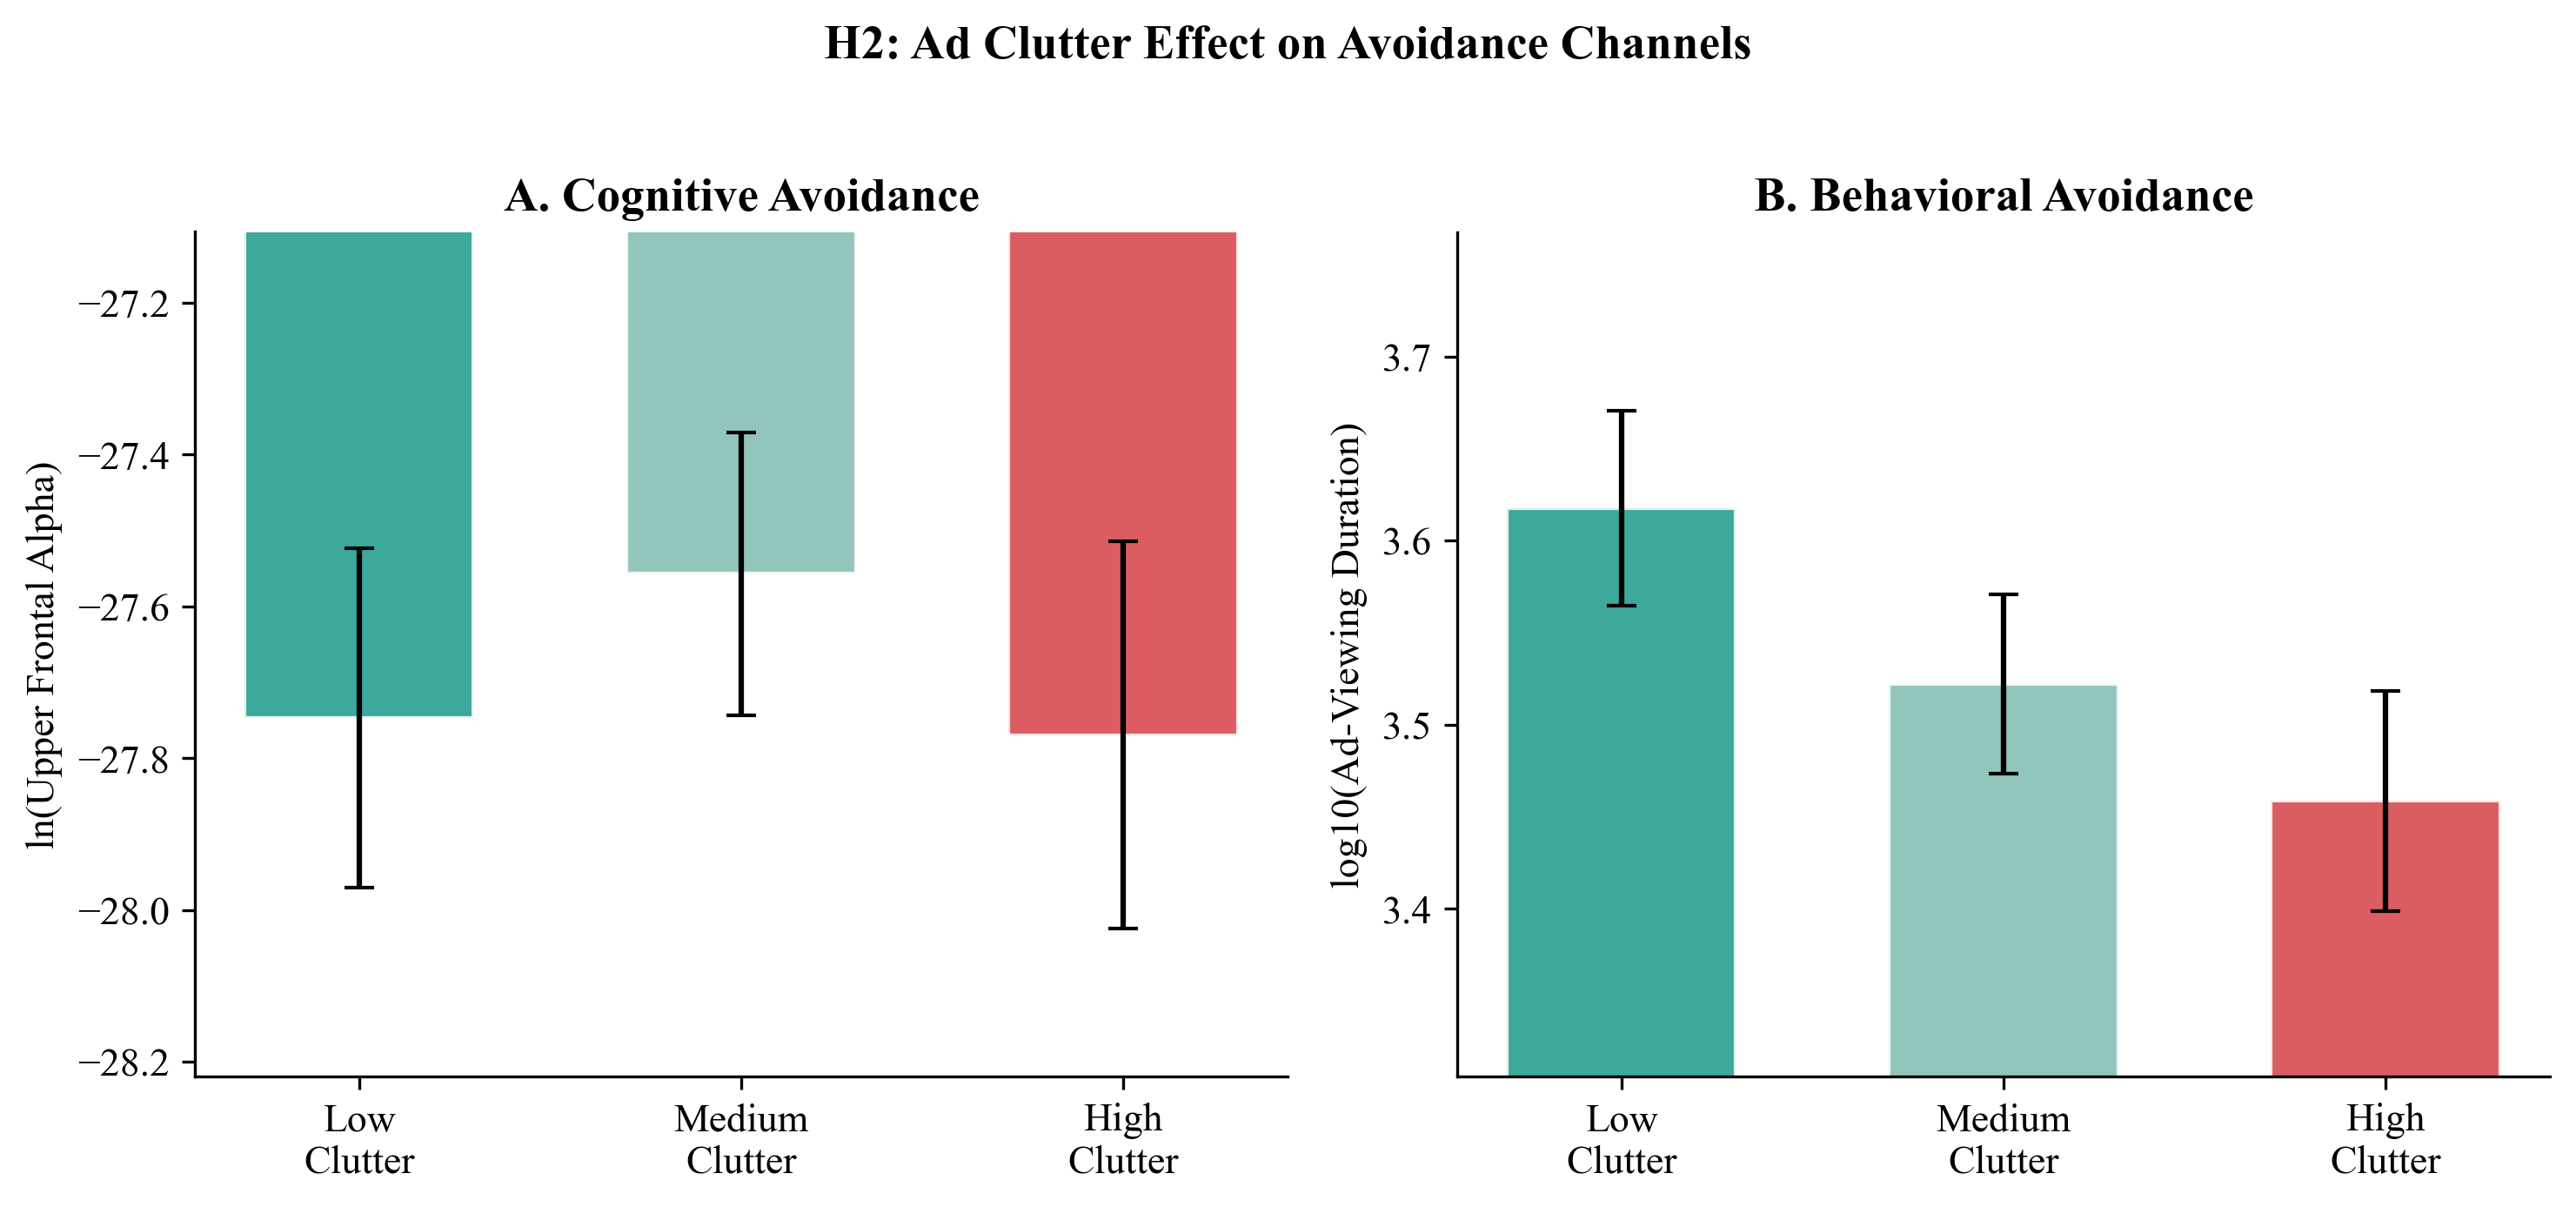

In [15]:
#7.2.: FIGURE H2: Side by side comparison of low/medim/high clutter for Cognitive and Behavioral Avoidance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

#group participants into 3 clutter groups
sc = df_ads.groupby("subject_id").agg(
    n_ads=("n_ads", "first"),
    alpha=("ln_upper_alpha_frontal_mean", "mean"),
    dur=("log_duration", "mean")
).reset_index()
sc["clutter"] = pd.qcut(sc["n_ads"], q=3, labels=["Low", "Medium", "High"])
colors = [C_CONTENT, "#7FBBAF", C_AD]

# LEFT: cognitive avoidance (alpha)
grp1 = sc.groupby("clutter", observed=True)["alpha"]
ax1.bar(range(3), grp1.mean().values, yerr=grp1.sem().values,
        color=colors, capsize=4, edgecolor="white", width=0.6, alpha=0.85)
ax1.set_xticks(range(3))
ax1.set_xticklabels(["Low\nClutter", "Medium\nClutter", "High\nClutter"])
ax1.set_ylabel("ln(Upper Frontal Alpha)")
ax1.set_title("A. Cognitive Avoidance", fontweight="bold")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylim(grp1.mean().min() - 0.45, grp1.mean().max() + 0.45)
# RIGHT: behavioral avoidance (duration)
grp2 = sc.groupby("clutter", observed=True)["dur"]
ax2.bar(range(3), grp2.mean().values, yerr=grp2.sem().values,
        color=colors, capsize=4, edgecolor="white", width=0.6, alpha=0.85)
ax2.set_xticks(range(3))
ax2.set_xticklabels(["Low\nClutter", "Medium\nClutter", "High\nClutter"])
ax2.set_ylabel("log10(Ad-Viewing Duration)")
ax2.set_title("B. Behavioral Avoidance", fontweight="bold")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_ylim(grp2.mean().min() - 0.15, grp2.mean().max() + 0.15)
fig.suptitle("H2: Ad Clutter Effect on Avoidance Channels", fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("Figure_H2_Clutter.png", bbox_inches="tight")
plt.show()

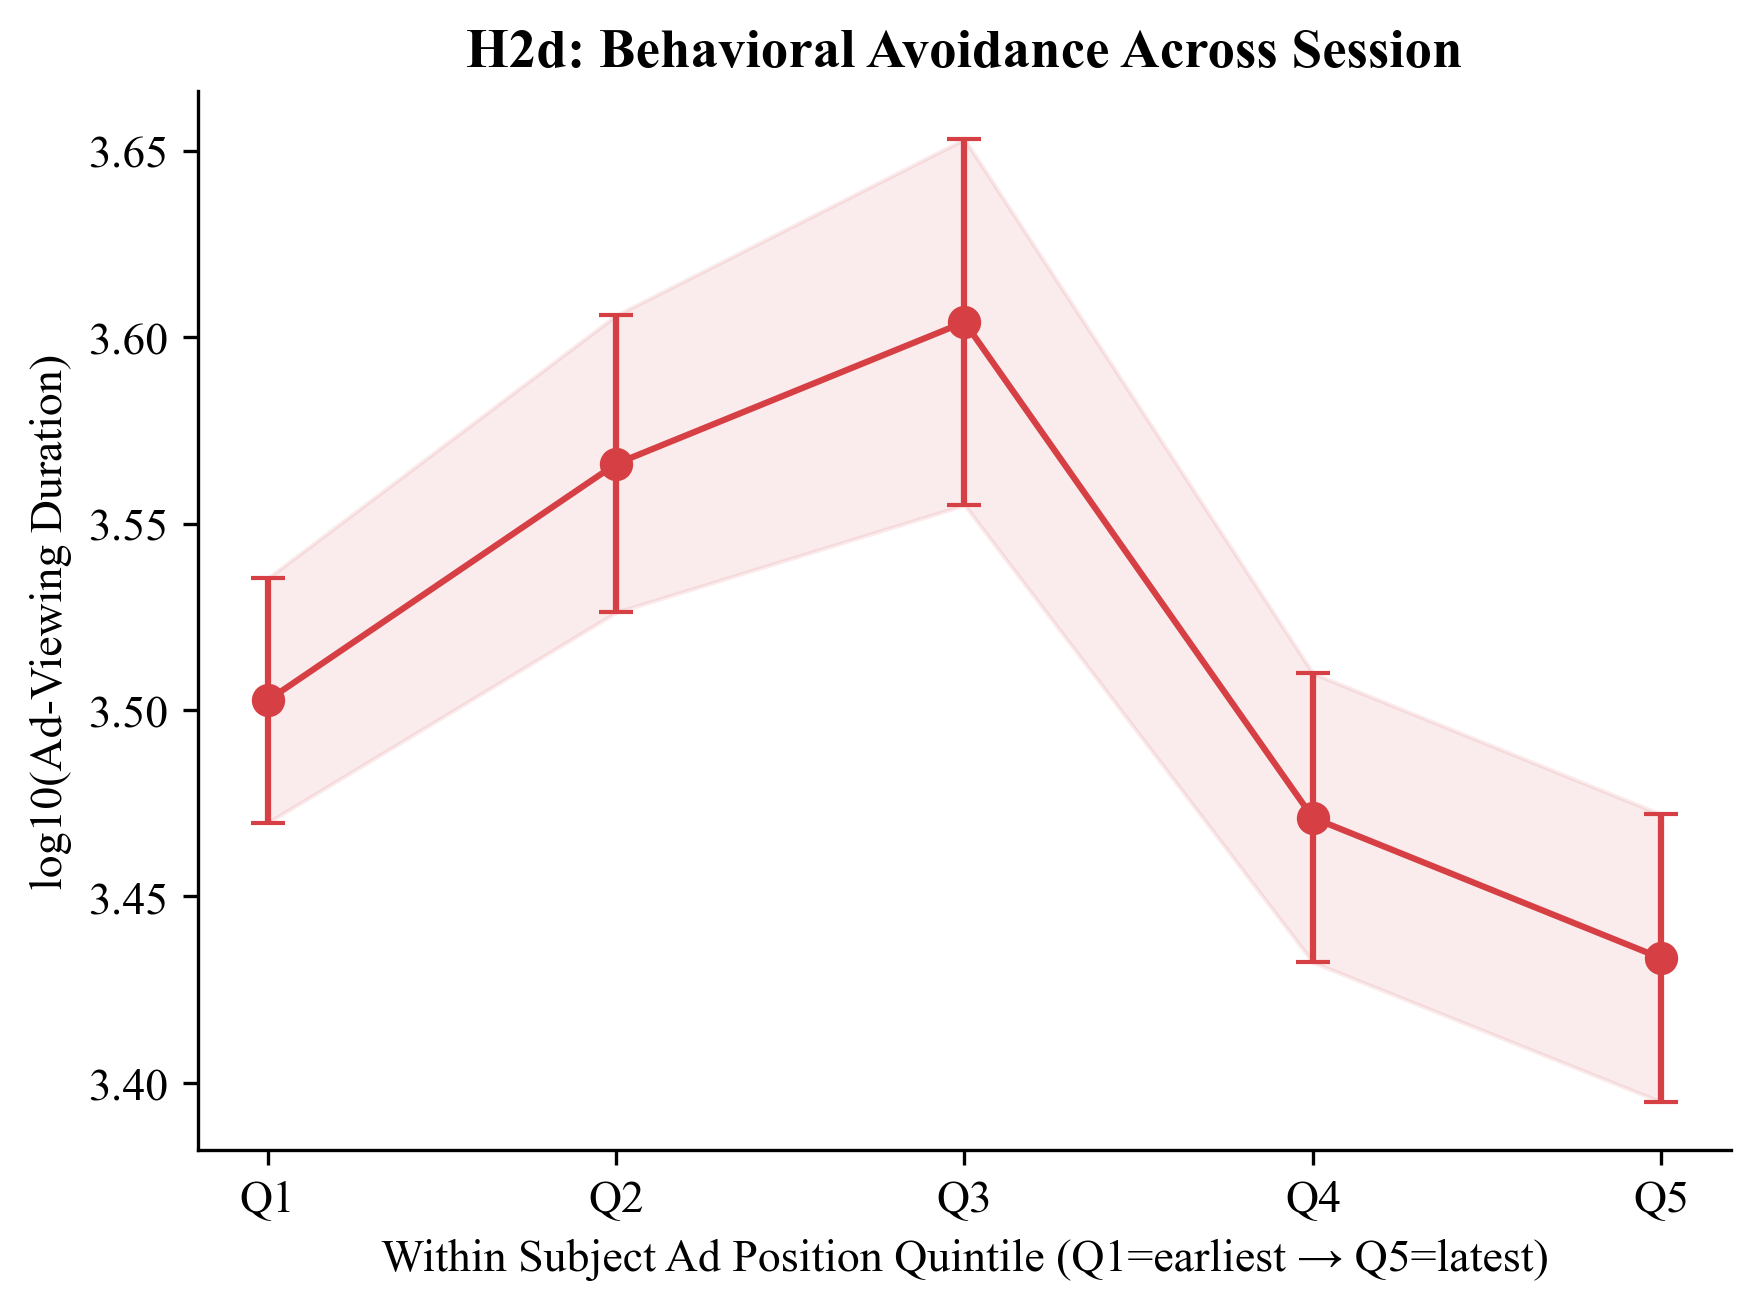

In [16]:
#7.3.: H2d: Line chart showing the how ad-viewing duration changes with ad position.
fig, ax = plt.subplots(figsize=(6, 4.5))

#split ad positions into 5 equal groups
df_ads["position_bin"] = pd.qcut(df_ads["ad_position_c"], q=5, labels=False, duplicates="drop")
grp = df_ads.groupby("position_bin")["log_duration"]

#line plot with error bars and shaded area
ax.errorbar(range(len(grp.mean())), grp.mean().values, yerr=grp.sem().values,
            fmt="o-", color=C_AD, markersize=7, capsize=4, lw=1.5)
ax.fill_between(range(len(grp.mean())),
                grp.mean().values - grp.sem().values,
                grp.mean().values + grp.sem().values,
                alpha=0.1, color=C_AD)

ax.set_xticks(range(len(grp.mean())))
ax.set_xticklabels([f"Q{i+1}" for i in range(len(grp.mean()))])
ax.set_xlabel("Within Subject Ad Position Quintile (Q1=earliest → Q5=latest)")
ax.set_ylabel("log10(Ad-Viewing Duration)")
ax.set_title("H2d: Behavioral Avoidance Across Session", fontweight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Figure_H2d.png", bbox_inches="tight")
plt.show()

In [17]:
#8.1.: H3: Brand Recall Test with GEE
print("\nH3: Brand Recall")
df_rec = df_ads.dropna(subset=["is_recall","ln_upper_alpha_frontal_mean","log_duration"])
df_rec["is_recall"] = df_rec["is_recall"].astype(int)
print(f"Recall: {df_rec["is_recall"].mean()*100:.2f}% ({df_rec["is_recall"].sum()}/{len(df_rec)})")

#GEE Model
gee = sm.GEE.from_formula(
 "is_recall ~ ln_upper_alpha_frontal_mean + log_duration + ad_position_c * n_ads_z"  ,
 groups= "subject_id", data= df_rec, family = sm.families.Binomial(),
 cov_struct = sm.cov_struct.Exchangeable()
).fit()

print("\nH3 GEE Results Summary")
print(gee.summary())

#Mixed model for robustness check
lpm = smf.mixedlm("is_recall ~ ln_upper_alpha_frontal_mean + log_duration + ad_position_c * n_ads_z",
                   data=df_rec, groups="subject_id").fit(reml=True, method="lbfgs")
print("\nMixed Model (robustness):")
print(lpm.summary())


H3: Brand Recall
Recall: 3.83% (20/522)

H3 GEE Results Summary
                               GEE Regression Results                              
Dep. Variable:                   is_recall   No. Observations:                  522
Model:                                 GEE   No. clusters:                       84
Method:                        Generalized   Min. cluster size:                   2
                      Estimating Equations   Max. cluster size:                  18
Family:                           Binomial   Mean cluster size:                 6.2
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Mon, 23 Feb 2026   Scale:                           1.000
Covariance type:                    robust   Time:                         12:13:28
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [18]:
#LOSO Sensitivity Analysis
print("\nLOSO")
coefs = []
for s in df_rec["subject_id"].unique():
    try:
        res = sm.GEE.from_formula(
            "is_recall ~ ln_upper_alpha_frontal_mean + log_duration + ad_position_c * n_ads_z",
            groups="subject_id", data=df_rec[df_rec["subject_id"] != s],
            family=sm.families.Binomial(), cov_struct=sm.cov_struct.Exchangeable()).fit()
        coefs.append(res.params["ad_position_c"])
    except: pass

print(f"Mean β = {np.mean(coefs):.4f}, SD = {np.std(coefs):.4f}, Range: [{np.min(coefs):.4f}, {np.max(coefs):.4f}]")



LOSO
Mean β = 0.4142, SD = 0.0186, Range: [0.3590, 0.5072]


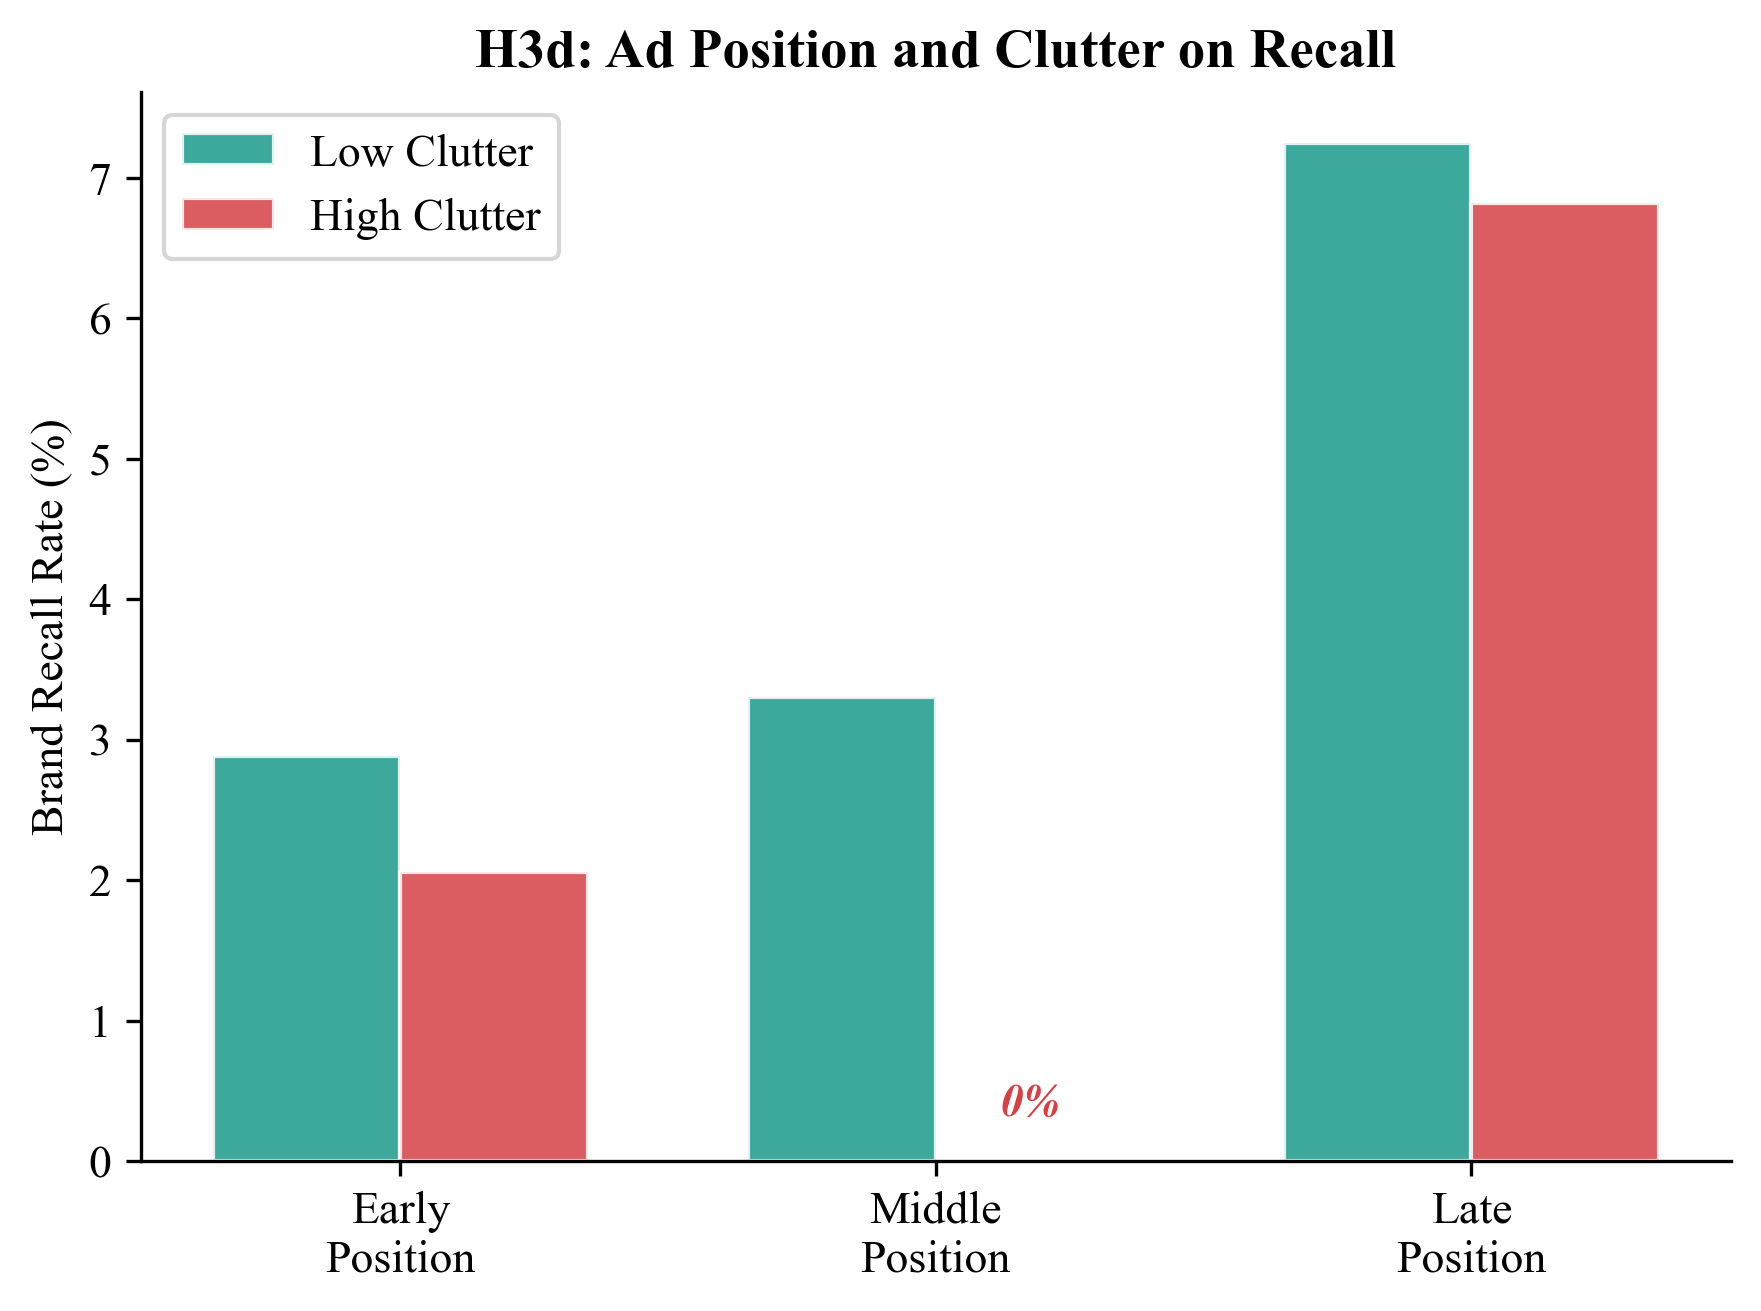

In [19]:
#8.2.: FIGURE H3: grouped bar charts demonstrating recall rates

fig, ax = plt.subplots(figsize= (6, 4.5))

#split ads depending on ad position (early/mid/late) and ad clutter (low/high)
df_rec["pos_group"] = pd.qcut(df_rec["ad_position_c"], q = 3, labels=["Early", "Middle", "Late"], duplicates= "drop")
clut_med = df_rec["n_ads_z"].median()
df_rec["clut_lev"] = np.where(df_rec["n_ads_z"] <= clut_med, "Low Clutter", "High Clutter")

#computing the recall rates for each group
recall_rate = df_rec.groupby(["pos_group", "clut_lev"], observed= True)["is_recall"].mean() * 100

#values for visualizing
x = np.arange(3)
w = 0.35
lc = [recall_rate.get(("Early", "Low Clutter"), 0),
      recall_rate.get(("Middle", "Low Clutter"), 0), 
      recall_rate.get(("Late", "Low Clutter"), 0)]
hc = [recall_rate.get(("Early", "High Clutter"), 0),
      recall_rate.get(("Middle", "High Clutter"), 0), 
      recall_rate.get(("Late", "High Clutter"), 0)]

ax.bar(x-w/2, lc, w, label = "Low Clutter", color = C_CONTENT, alpha = 0.85, edgecolor = "white")
ax.bar(x+w/2, hc, w, label = "High Clutter", color = C_AD, alpha = 0.85, edgecolor = "white")

ax.set_xticks(x)
ax.set_xticklabels(["Early\nPosition", "Middle\nPosition", "Late\nPosition"])
ax.set_ylabel("Brand Recall Rate (%)")
ax.set_title("H3d: Ad Position and Clutter on Recall", fontweight = "bold")
ax.legend(loc = "upper left")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
if hc[1] == 0:
    ax.text(1 + w/2, 0.25, "0%", ha="center", va="bottom", fontsize=11, color=C_AD, fontstyle="italic", fontweight = "bold")
plt.tight_layout()
plt.savefig("Figure_H3_Recall.png", bbox_inches="tight")
plt.show()

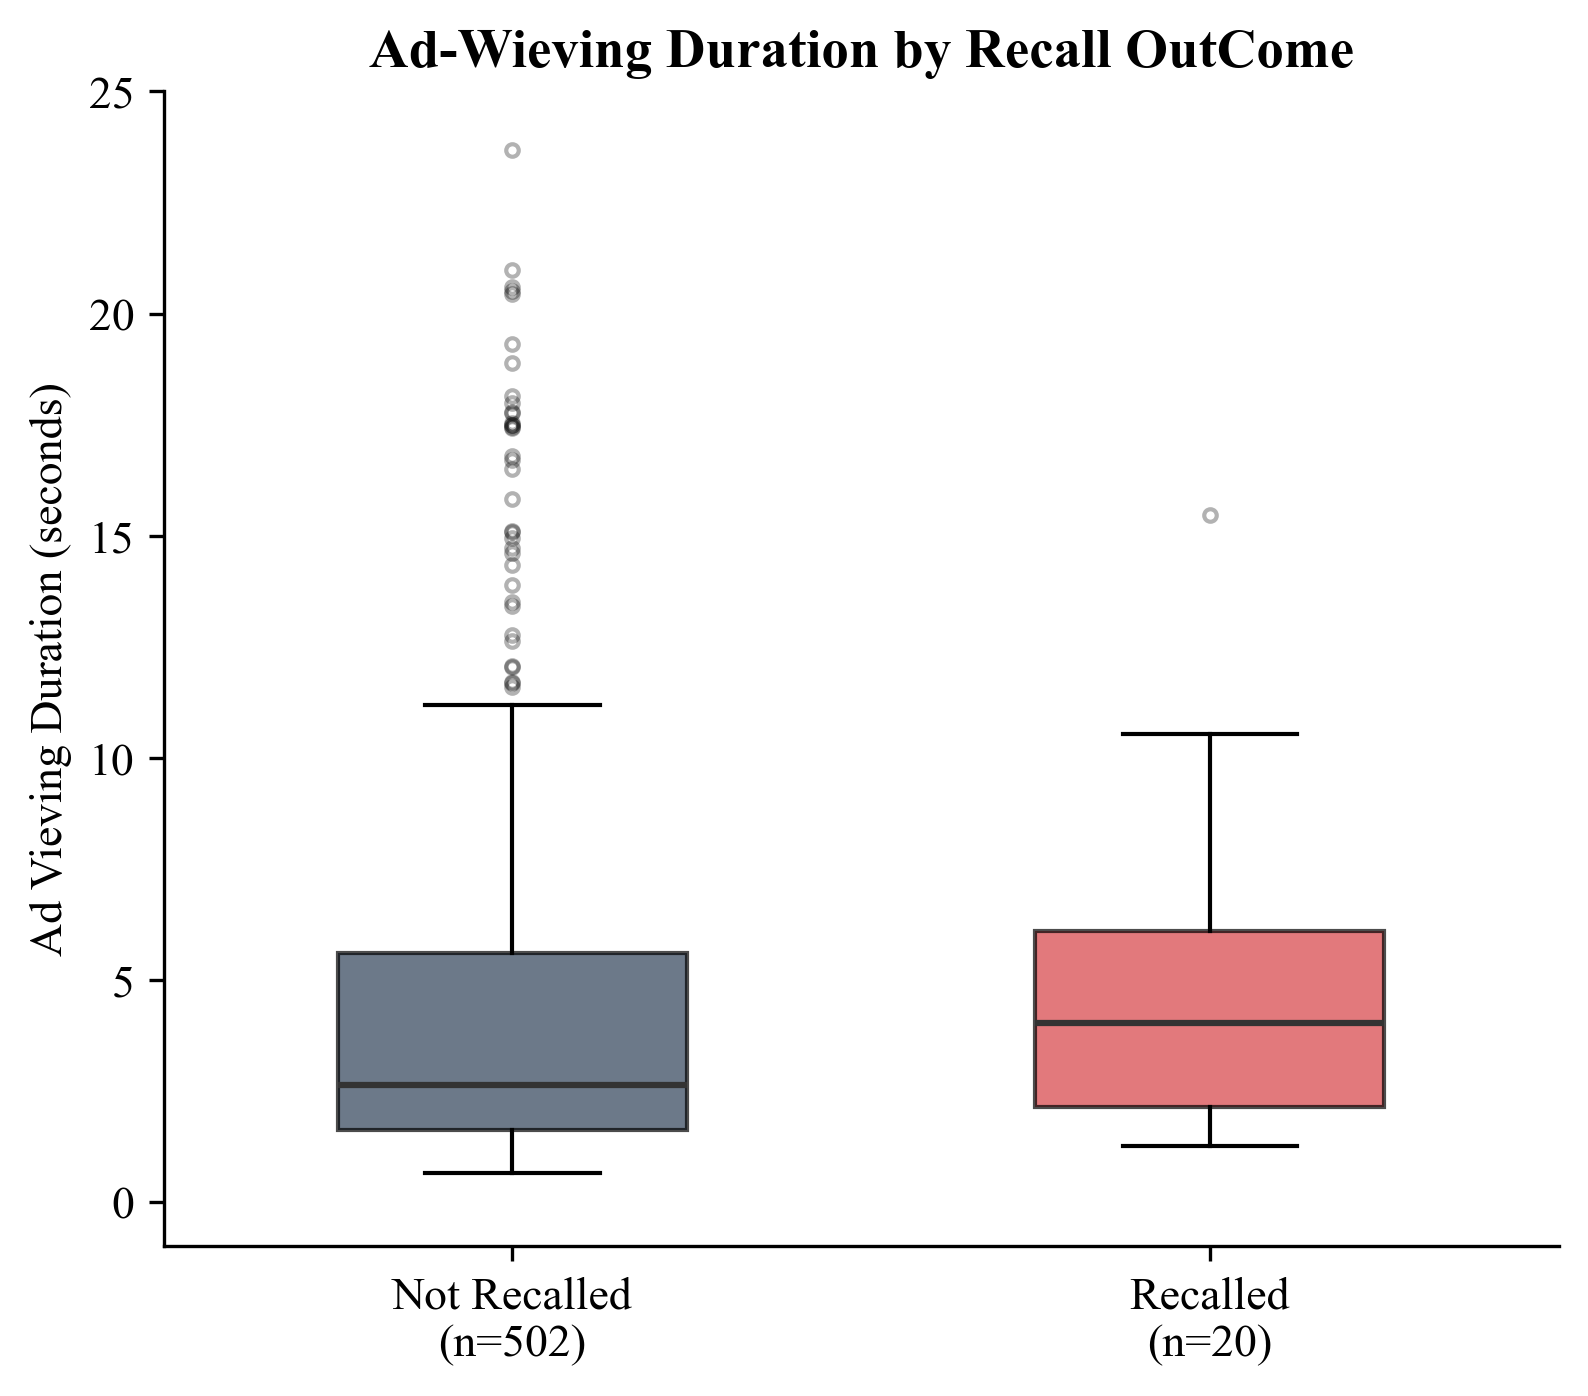

In [20]:
#8.3: FIGURE.2 H3: 
fig, ax = plt.subplots(figsize= (6, 5))

recalled = df_rec[df_rec["is_recall"] == 1]["duration"]/ 1000
not_recalled = df_rec[df_rec["is_recall"]== 0]["duration"]/1000

bp = ax.boxplot([not_recalled, recalled], labels=["Not Recalled\n(n={})".format(len(not_recalled)),
                "Recalled\n(n={})".format(len(recalled))],
                patch_artist = True, widths=0.5,
                medianprops = dict(color = '#333', lw=1.5),
                flierprops = dict(marker = "o", markersize = 3, alpha = 0.3))
bp["boxes"][0].set_facecolor(C_ACCENT)
bp["boxes"][0].set_alpha(0.7)
bp["boxes"][1].set_facecolor(C_AD)
bp["boxes"][1].set_alpha(0.7)

ax.set_ylabel("Ad Vieving Duration (seconds)")
ax.set_title("Ad-Wieving Duration by Recall OutCome", fontweight = "bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(-1, 25)
plt.savefig("Figure_H3b_BoxPlot_Duration_Recall.png", bbox_inches="tight")
plt.show()

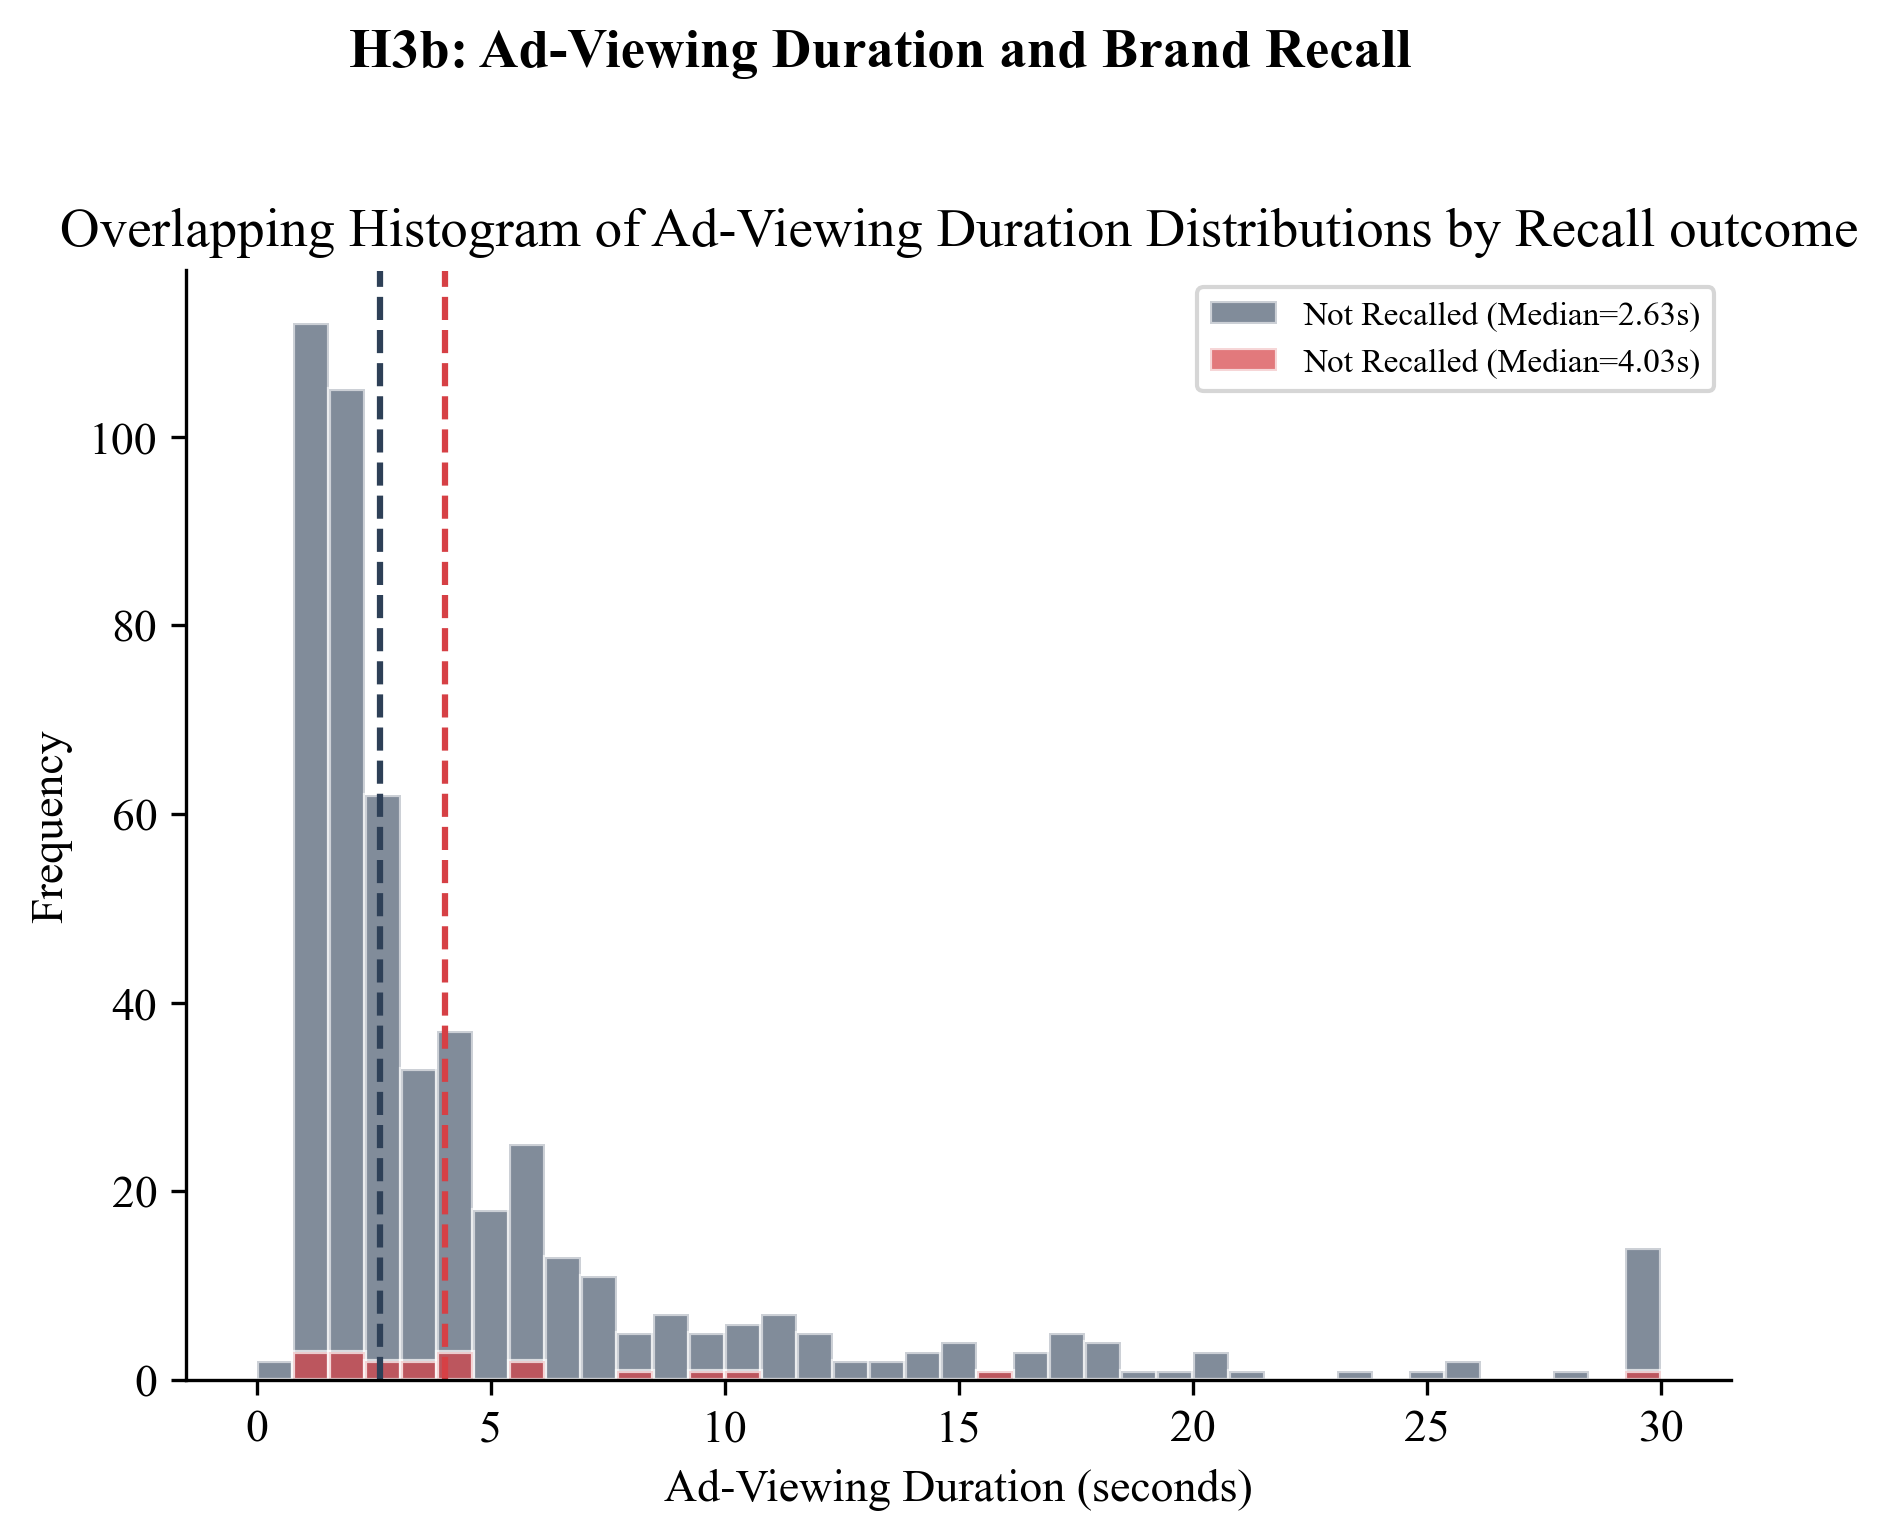

In [21]:
#8.4.: Ad-viewing duration and brand recall
fig, ax = plt.subplots(figsize= (6, 5))
bins = np.linspace(0,30,40)
ax.hist(not_recalled.clip(upper=30), bins = bins, color = C_ACCENT, alpha =0.6,
        label = f"Not Recalled (Median={not_recalled.median():.2f}s)", edgecolor="white")
ax.hist(recalled.clip(upper=30), bins = bins, color = C_AD, alpha =0.7,
        label = f"Not Recalled (Median={recalled.median():.2f}s)", edgecolor="white")

ax.axvline(not_recalled.median(), color = C_ACCENT, ls= "--", lw=1.5)
ax.axvline(recalled.median(), color = C_AD, ls= "--", lw=1.5)

ax.set_xlabel("Ad-Viewing Duration (seconds)")
ax.set_ylabel("Frequency")
ax.set_title("Overlapping Histogram of Ad-Viewing Duration Distributions by Recall outcome")
ax.legend(fontsize = 8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.suptitle("H3b: Ad-Viewing Duration and Brand Recall", fontweight = "bold", y=1.02)
plt.tight_layout()
plt.savefig("Figure_H3b_Histogram_Duration_Recall.png", bbox_inches="tight")
plt.show()

In [22]:
print("HYPOTHESIS SUMMARY")
print("="*60)
def status(p): return "SUPPORTED" if p < 0.05 else "NOT SUPPORTED"
print(f"H1a  Ads→Alpha:       β={model_h1a.params['is_ad']:.3f}, p={model_h1a.pvalues['is_ad']:.3f}  {status(model_h1a.pvalues['is_ad'])}")
print(f"H1b  Duration<5s:     Mdn={df_ads['duration'].median()/1000:.2f}s  SUPPORTED")
print(f"H1c  Alpha↔Duration:  β={m_dur.params['ln_upper_alpha_frontal_mean']:.3f}, p={m_dur.pvalues['ln_upper_alpha_frontal_mean']:.3f}  {status(m_dur.pvalues['ln_upper_alpha_frontal_mean'])}")
print(f"H2a  Clutter→Alpha:   β={M1.params['n_ads_z']:.3f}, p={M1.pvalues['n_ads_z']:.3f}  {status(M1.pvalues['n_ads_z'])}")
print(f"H2b  Clutter→Duration:β={model_behav.params['n_ads_z']:.3f}, p={model_behav.pvalues['n_ads_z']:.3f}  {status(model_behav.pvalues['n_ads_z'])}")
print(f"H2c  Position→Alpha:  β={M1.params['ad_position_c']:.3f}, p={M1.pvalues['ad_position_c']:.3f}  {status(M1.pvalues['ad_position_c'])}")
print(f"H2d  Position→Duration:β={model_behav.params['ad_position_c']:.3f}, p={model_behav.pvalues['ad_position_c']:.3f}  {status(model_behav.pvalues['ad_position_c'])}")
print(f"H3a  Alpha→Recall:    β={gee.params['ln_upper_alpha_frontal_mean']:.3f}, p={gee.pvalues['ln_upper_alpha_frontal_mean']:.3f}  {status(gee.pvalues['ln_upper_alpha_frontal_mean'])}")
print(f"H3b  Duration→Recall: β={gee.params['log_duration']:.3f}, p={gee.pvalues['log_duration']:.3f}  {status(gee.pvalues['log_duration'])}")
print(f"H3c  Clutter→Recall:  β={gee.params['n_ads_z']:.3f}, p={gee.pvalues['n_ads_z']:.3f}  {status(gee.pvalues['n_ads_z'])}")
print(f"H3d  Position→Recall: β={gee.params['ad_position_c']:.3f}, p={gee.pvalues['ad_position_c']:.3f}  {status(gee.pvalues['ad_position_c'])}")


HYPOTHESIS SUMMARY
H1a  Ads→Alpha:       β=0.089, p=0.021  SUPPORTED
H1b  Duration<5s:     Mdn=2.67s  SUPPORTED
H1c  Alpha↔Duration:  β=-0.044, p=0.035  SUPPORTED
H2a  Clutter→Alpha:   β=0.027, p=0.840  NOT SUPPORTED
H2b  Clutter→Duration:β=-0.074, p=0.016  SUPPORTED
H2c  Position→Alpha:  β=0.002, p=0.907  NOT SUPPORTED
H2d  Position→Duration:β=-0.018, p=0.043  SUPPORTED
H3a  Alpha→Recall:    β=-0.075, p=0.565  NOT SUPPORTED
H3b  Duration→Recall: β=0.729, p=0.214  NOT SUPPORTED
H3c  Clutter→Recall:  β=0.111, p=0.600  NOT SUPPORTED
H3d  Position→Recall: β=0.414, p=0.008  SUPPORTED


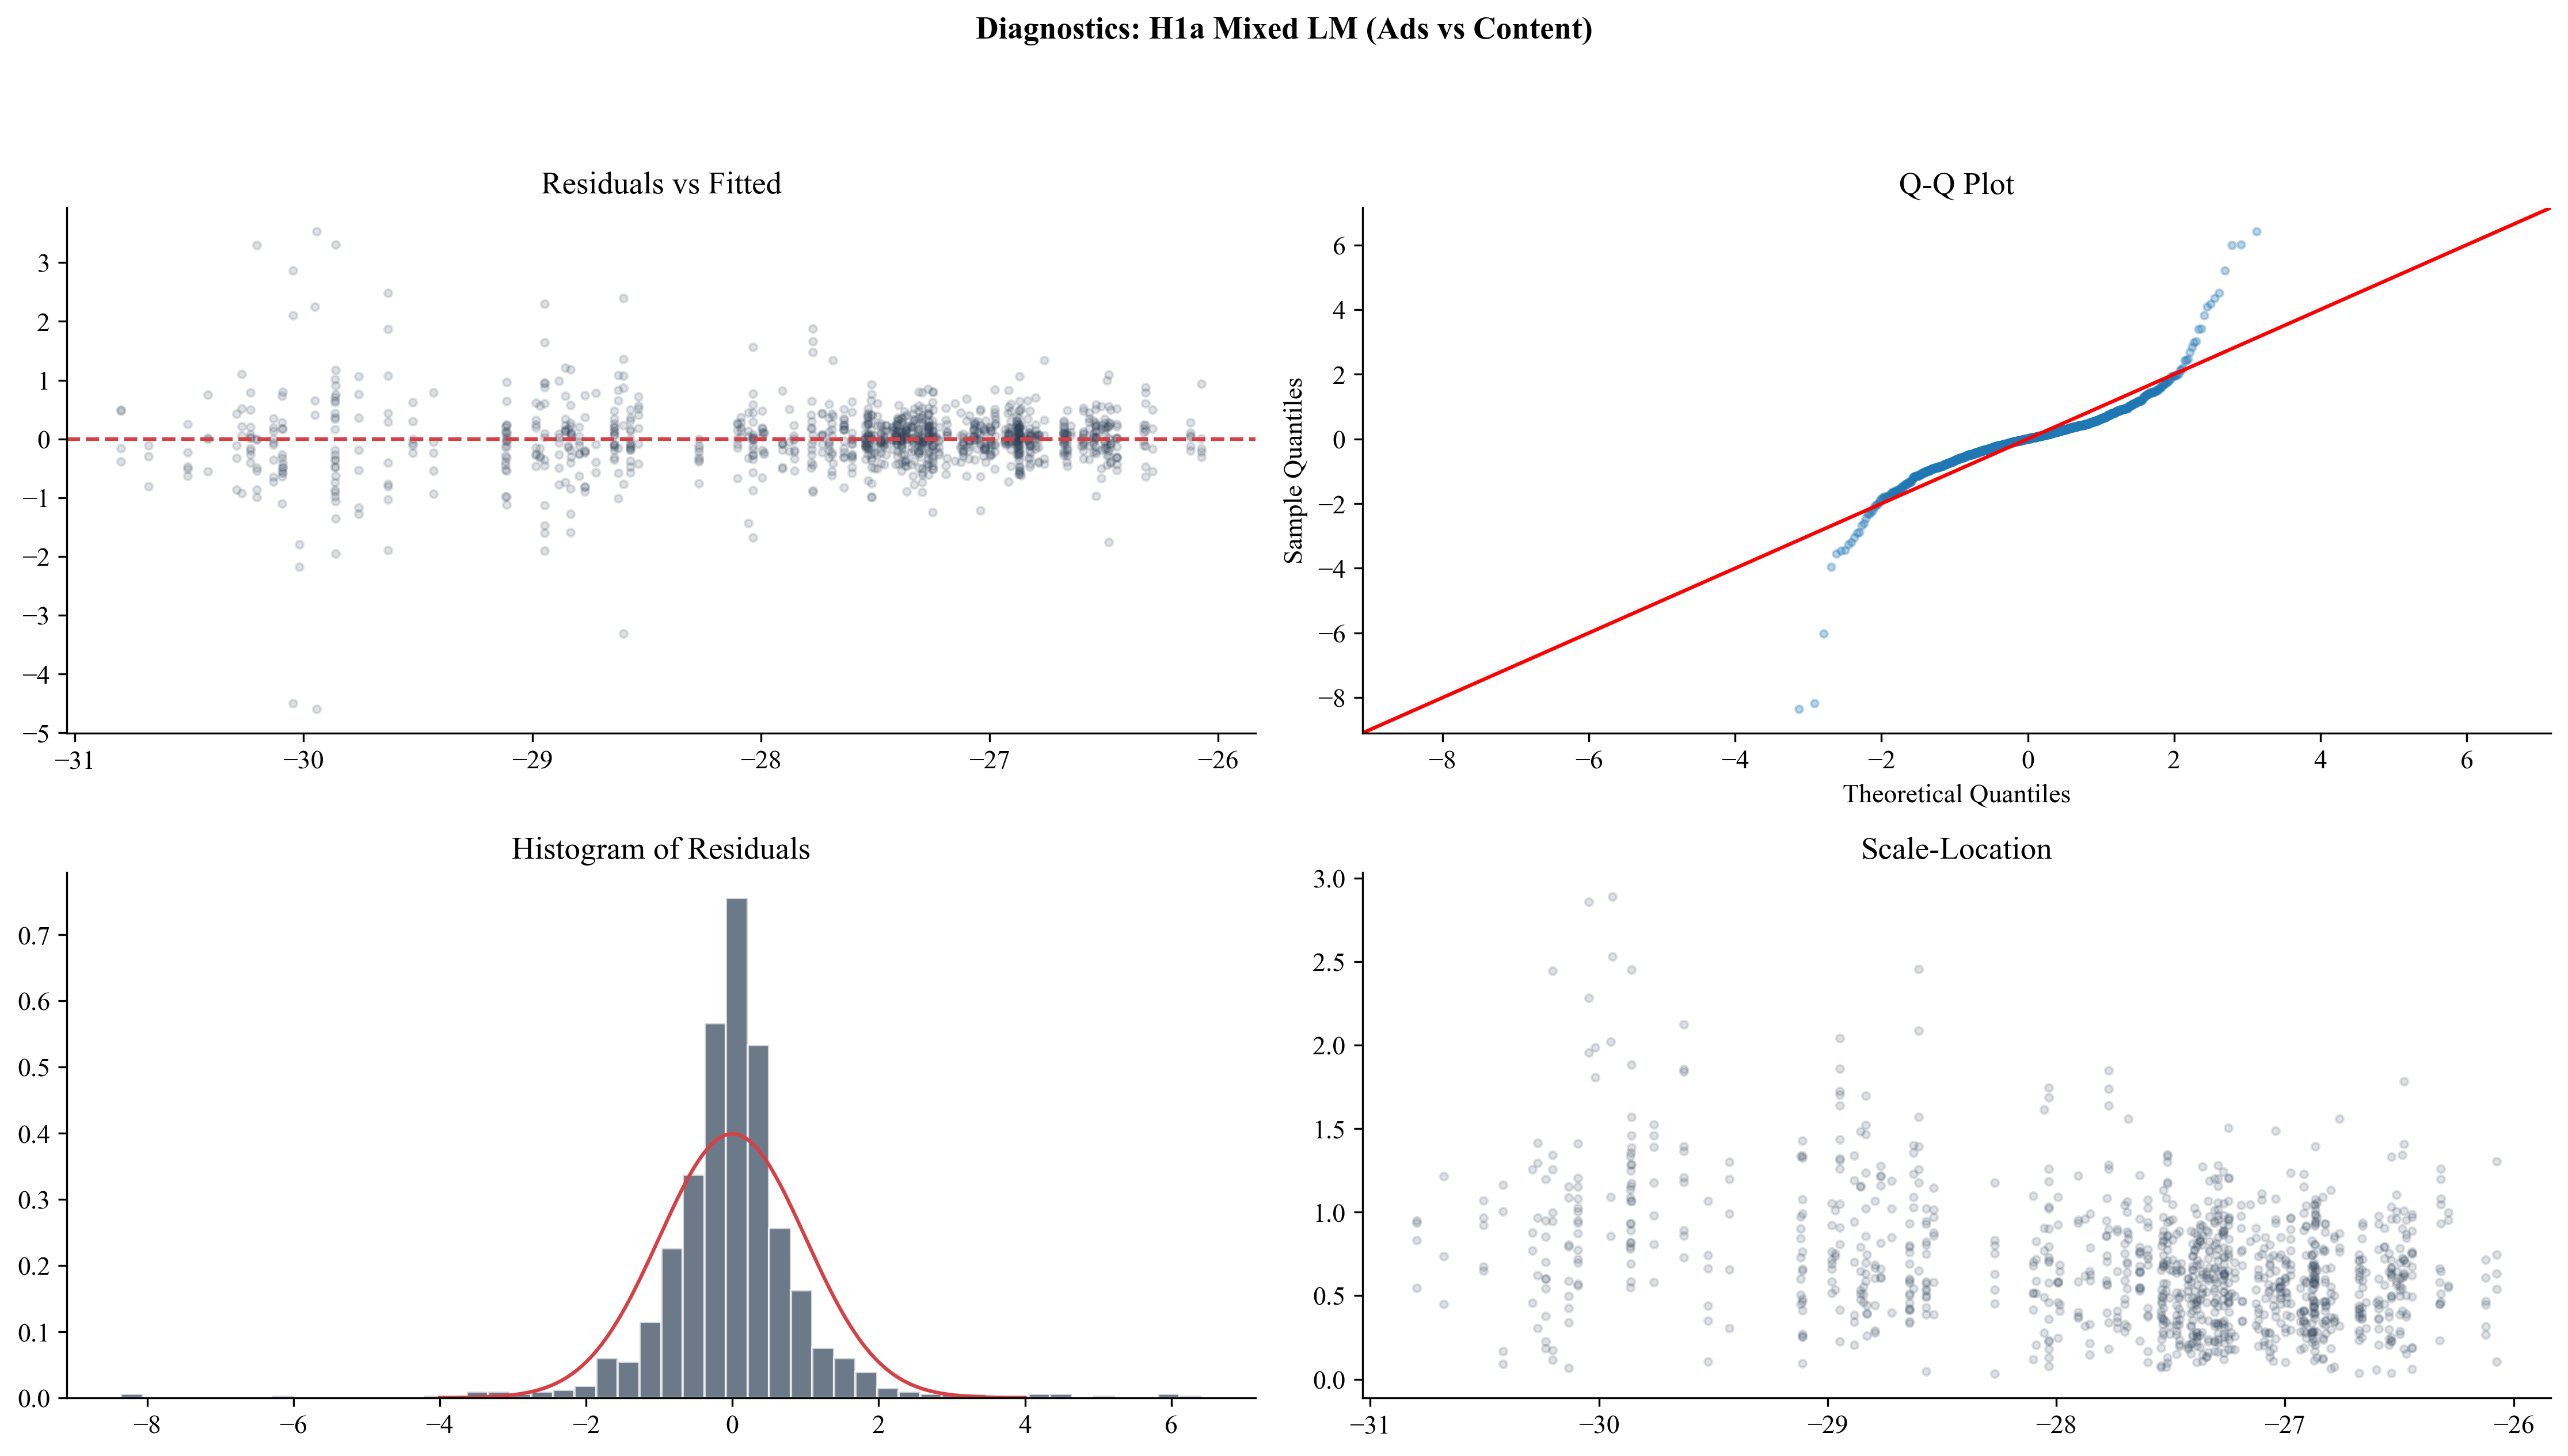

In [23]:
#DIAGNOSTIC PLOTS

# Mixed Model H1a: Ads vs Content
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Diagnostics: H1a Mixed LM (Ads vs Content)", fontweight="bold", y=1.05)

resid = model_h1a.resid
fitted = model_h1a.fittedvalues
std_resid = (resid - resid.mean()) / resid.std()

axes[0,0].scatter(fitted, resid, alpha=0.15, s=10, color=C_ACCENT)
axes[0,0].axhline(0, color=C_AD, ls="--")
axes[0,0].set_title("Residuals vs Fitted")

sm.qqplot(std_resid, line="45", ax=axes[0,1], markersize=3, alpha=0.3)
axes[0,1].set_title("Q-Q Plot")

axes[1,0].hist(std_resid, bins=50, color=C_ACCENT, alpha=0.7, edgecolor="white", density=True)
x_norm = np.linspace(-4, 4, 200)
axes[1,0].plot(x_norm, stats.norm.pdf(x_norm), color=C_AD)
axes[1,0].set_title("Histogram of Residuals")

axes[1,1].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.15, s=10, color=C_ACCENT)
axes[1,1].set_title("Scale-Location")


for ax in axes.flat: ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Diag_H1a.png", bbox_inches="tight")
plt.show()


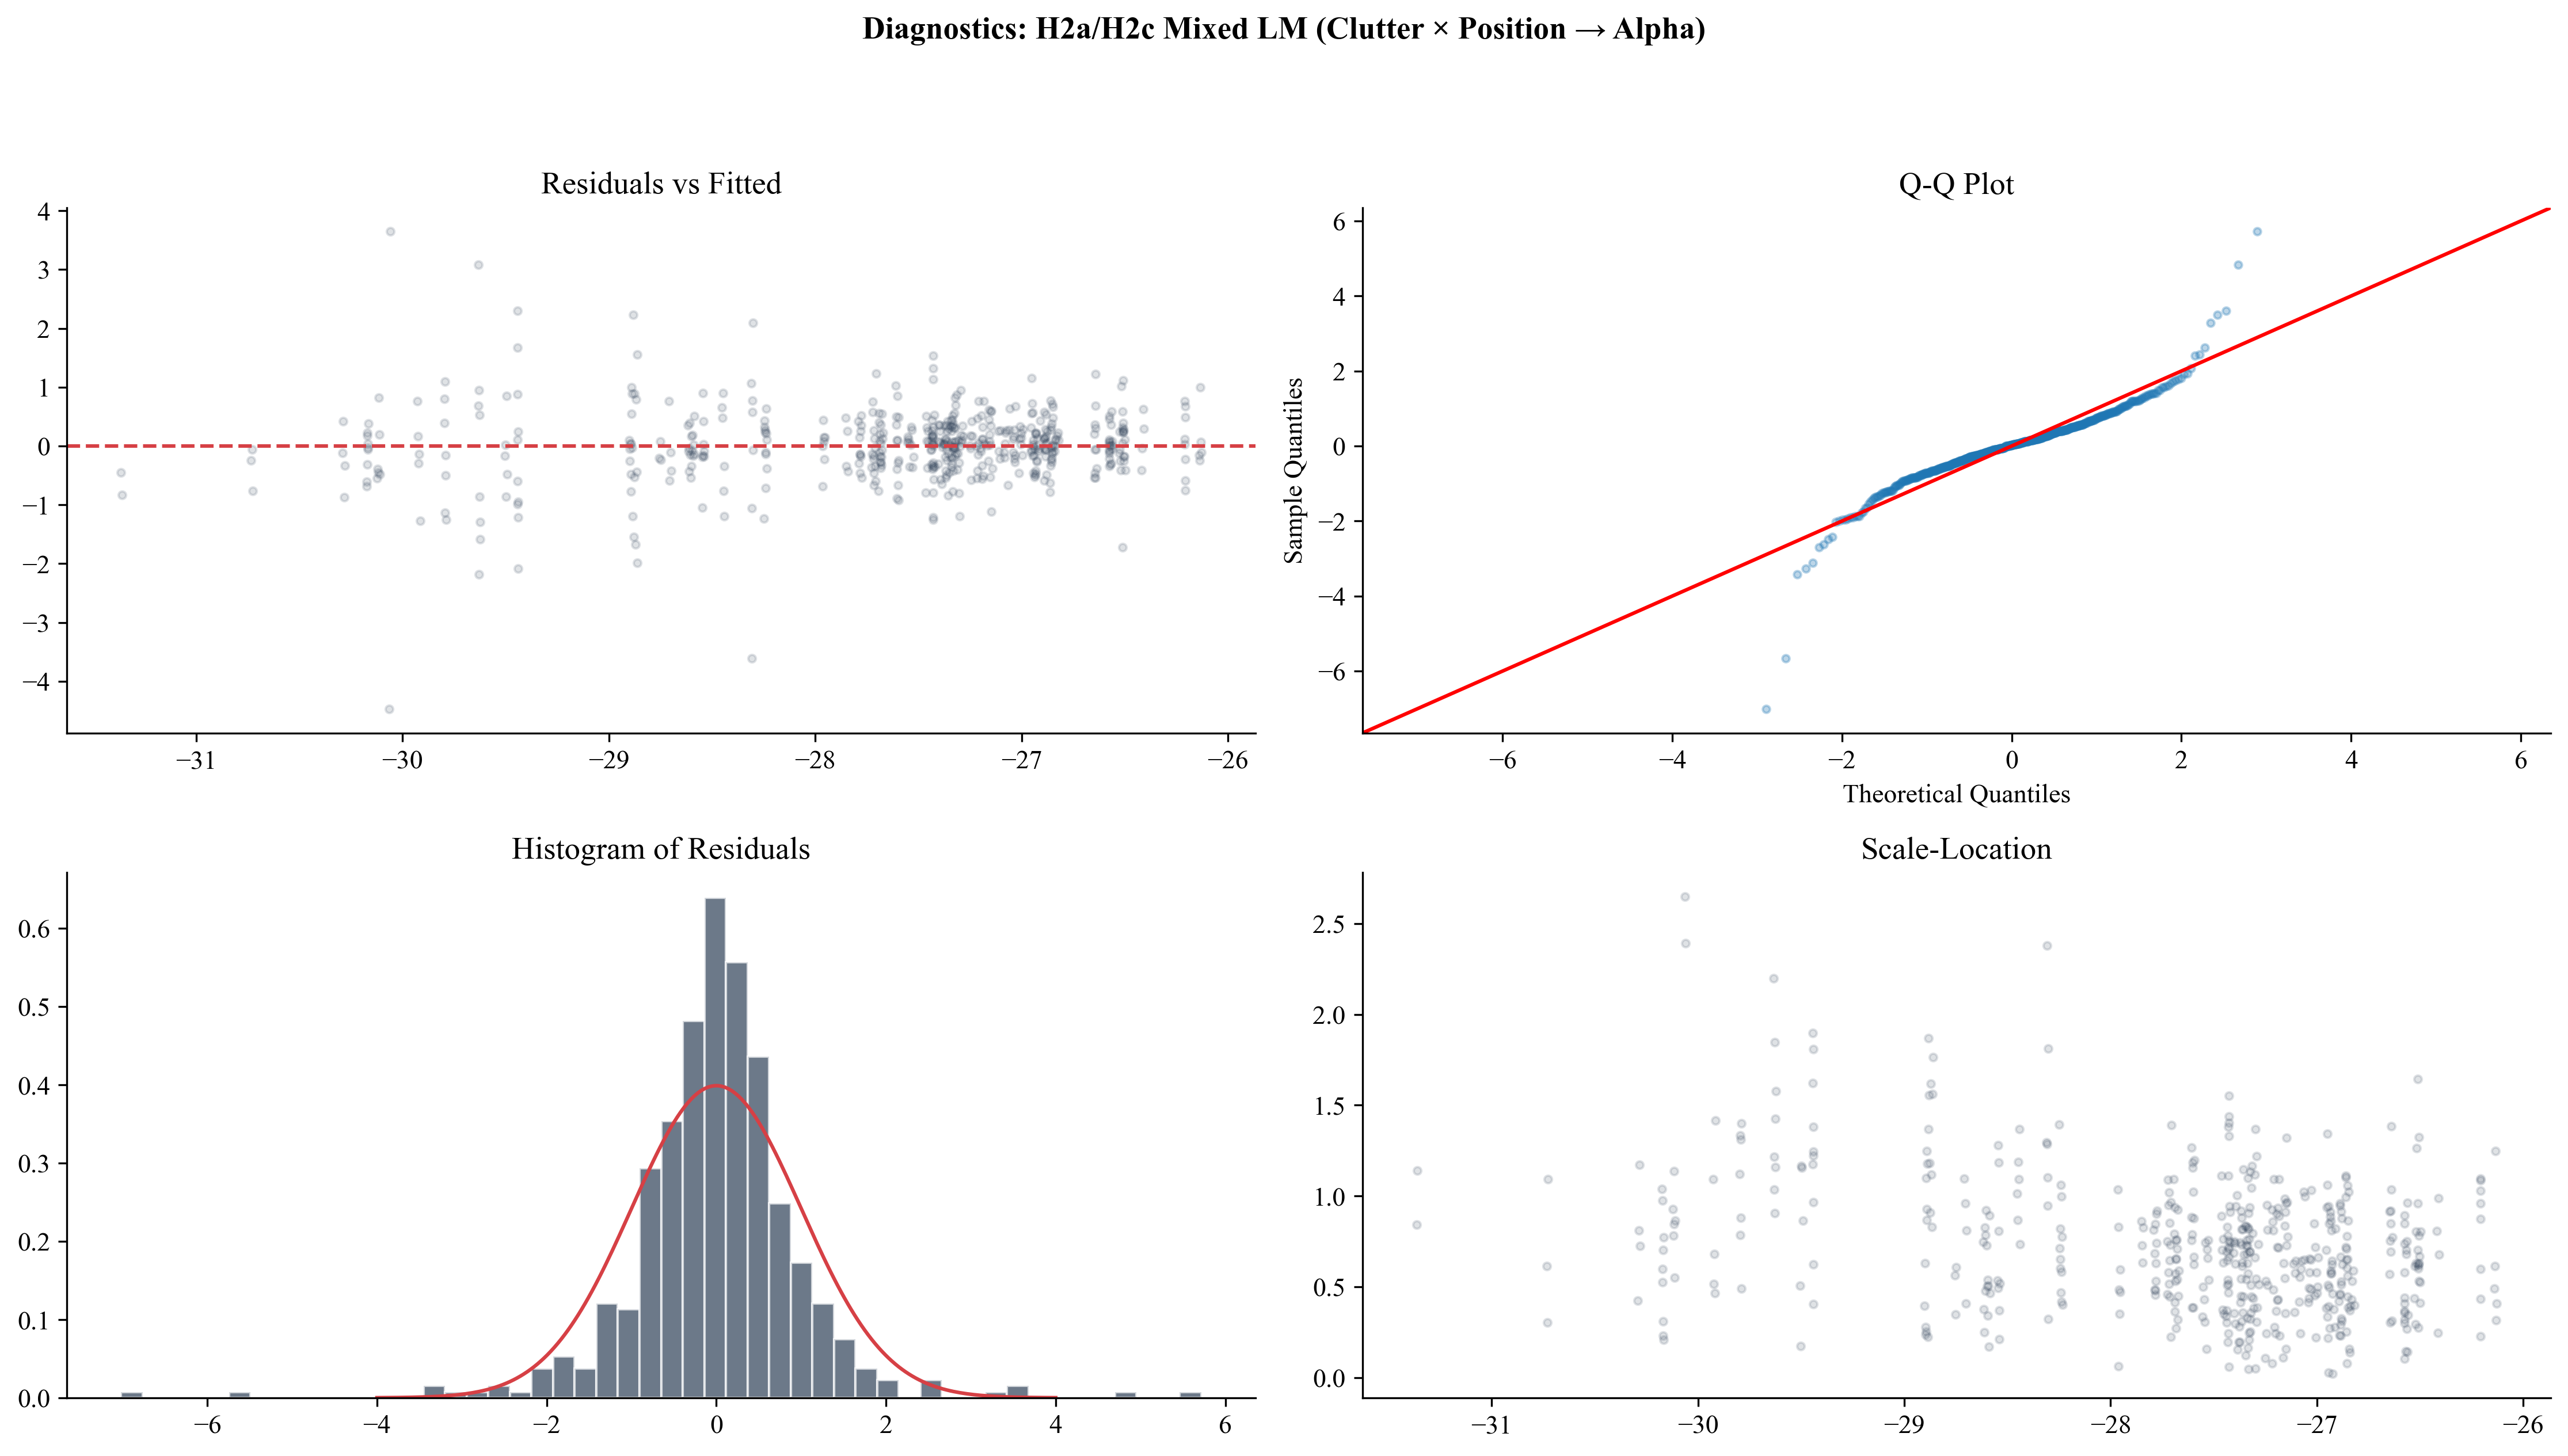

In [24]:
#Mixed Model H2a/H2c: Clutter x Position & ALpha Power
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Diagnostics: H2a/H2c Mixed LM (Clutter × Position → Alpha)", fontweight="bold", y=1.05)

resid = M1.resid
fitted = M1.fittedvalues
std_resid = (resid - resid.mean()) / resid.std()

axes[0,0].scatter(fitted, resid, alpha=0.15, s=10, color=C_ACCENT)
axes[0,0].axhline(0, color=C_AD, ls="--")
axes[0,0].set_title("Residuals vs Fitted")

sm.qqplot(std_resid, line="45", ax=axes[0,1], markersize=3, alpha=0.3)
axes[0,1].set_title("Q-Q Plot")

axes[1,0].hist(std_resid, bins=50, color=C_ACCENT, alpha=0.7, edgecolor="white", density=True)
x_norm = np.linspace(-4, 4, 200)
axes[1,0].plot(x_norm, stats.norm.pdf(x_norm), color=C_AD)
axes[1,0].set_title("Histogram of Residuals")

axes[1,1].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.15, s=10, color=C_ACCENT)
axes[1,1].set_title("Scale-Location")


for ax in axes.flat: ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Diag_H1a.png", bbox_inches="tight")
plt.show()

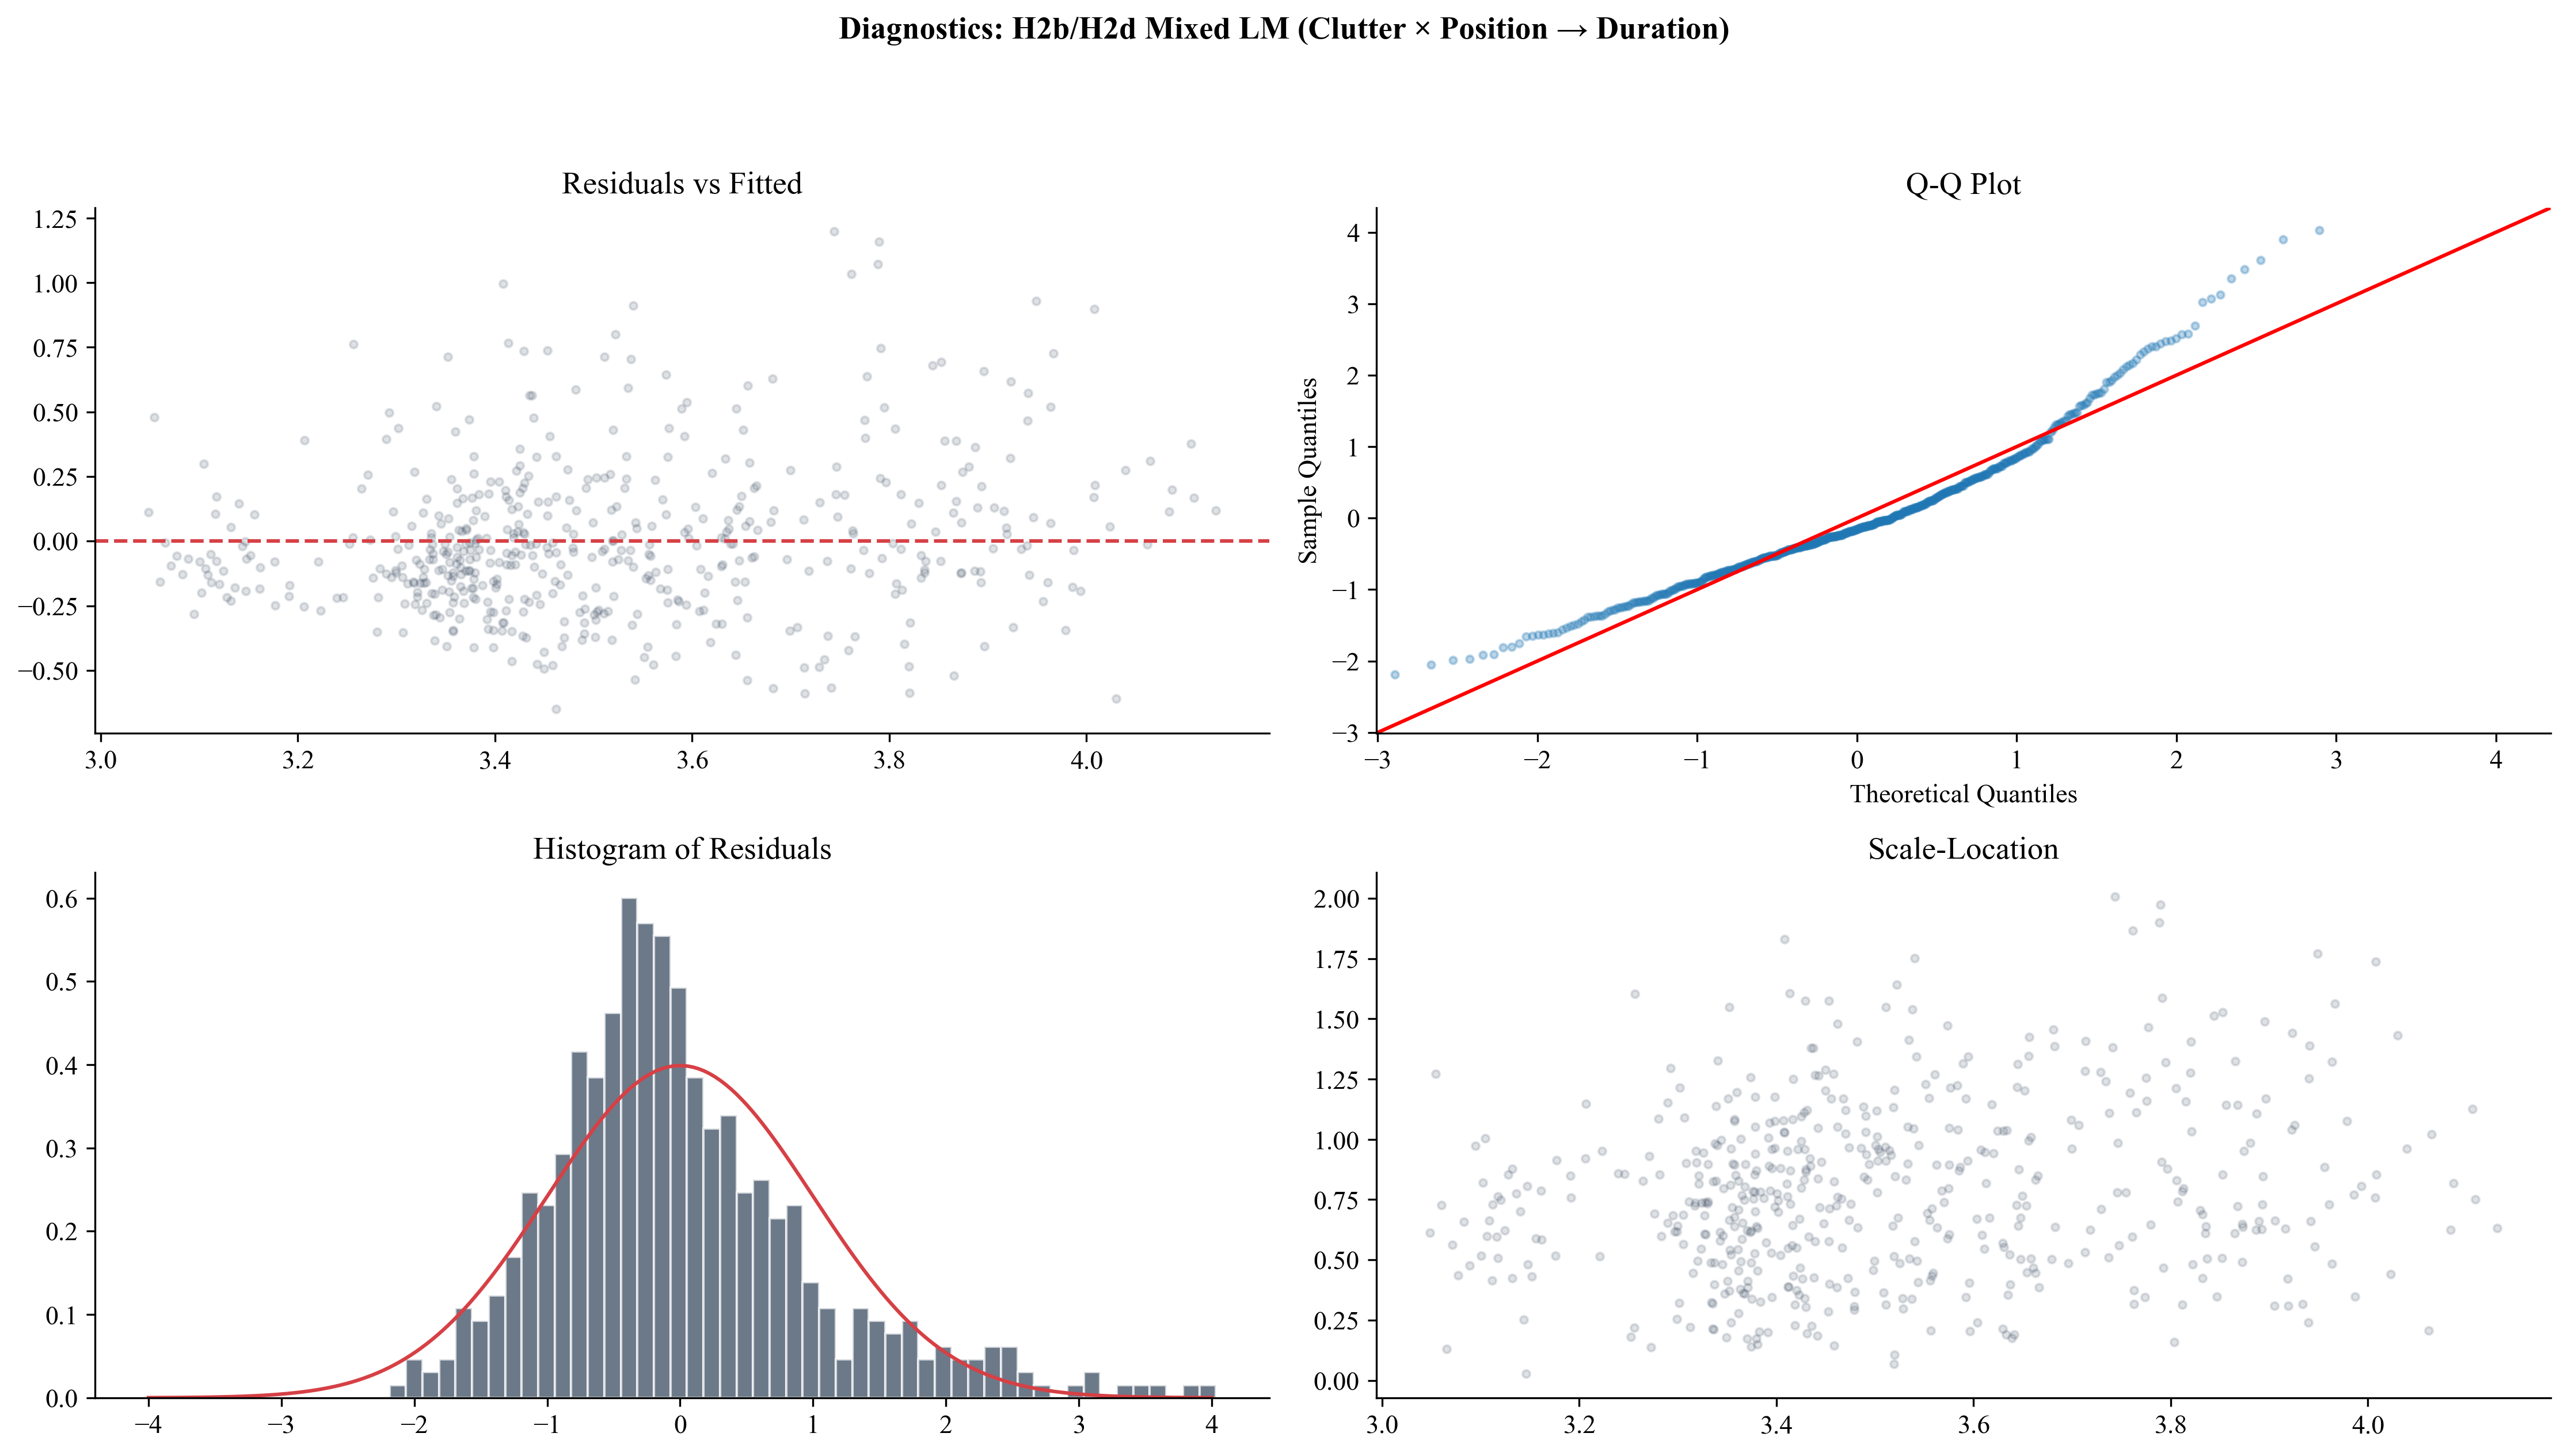

In [25]:
#Mixed Model H2b/H2d: Clutter x Position & Ad-viewing Duration
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Diagnostics: H2b/H2d Mixed LM (Clutter × Position → Duration)", fontweight="bold", y=1.05)

resid = model_behav.resid
fitted = model_behav.fittedvalues
std_resid = (resid - resid.mean()) / resid.std()

axes[0,0].scatter(fitted, resid, alpha=0.15, s=10, color=C_ACCENT)
axes[0,0].axhline(0, color=C_AD, ls="--")
axes[0,0].set_title("Residuals vs Fitted")

sm.qqplot(std_resid, line="45", ax=axes[0,1], markersize=3, alpha=0.3)
axes[0,1].set_title("Q-Q Plot")

axes[1,0].hist(std_resid, bins=50, color=C_ACCENT, alpha=0.7, edgecolor="white", density=True)
x_norm = np.linspace(-4, 4, 200)
axes[1,0].plot(x_norm, stats.norm.pdf(x_norm), color=C_AD)
axes[1,0].set_title("Histogram of Residuals")

axes[1,1].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.15, s=10, color=C_ACCENT)
axes[1,1].set_title("Scale-Location")


for ax in axes.flat: ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Diag_H1a.png", bbox_inches="tight")
plt.show()

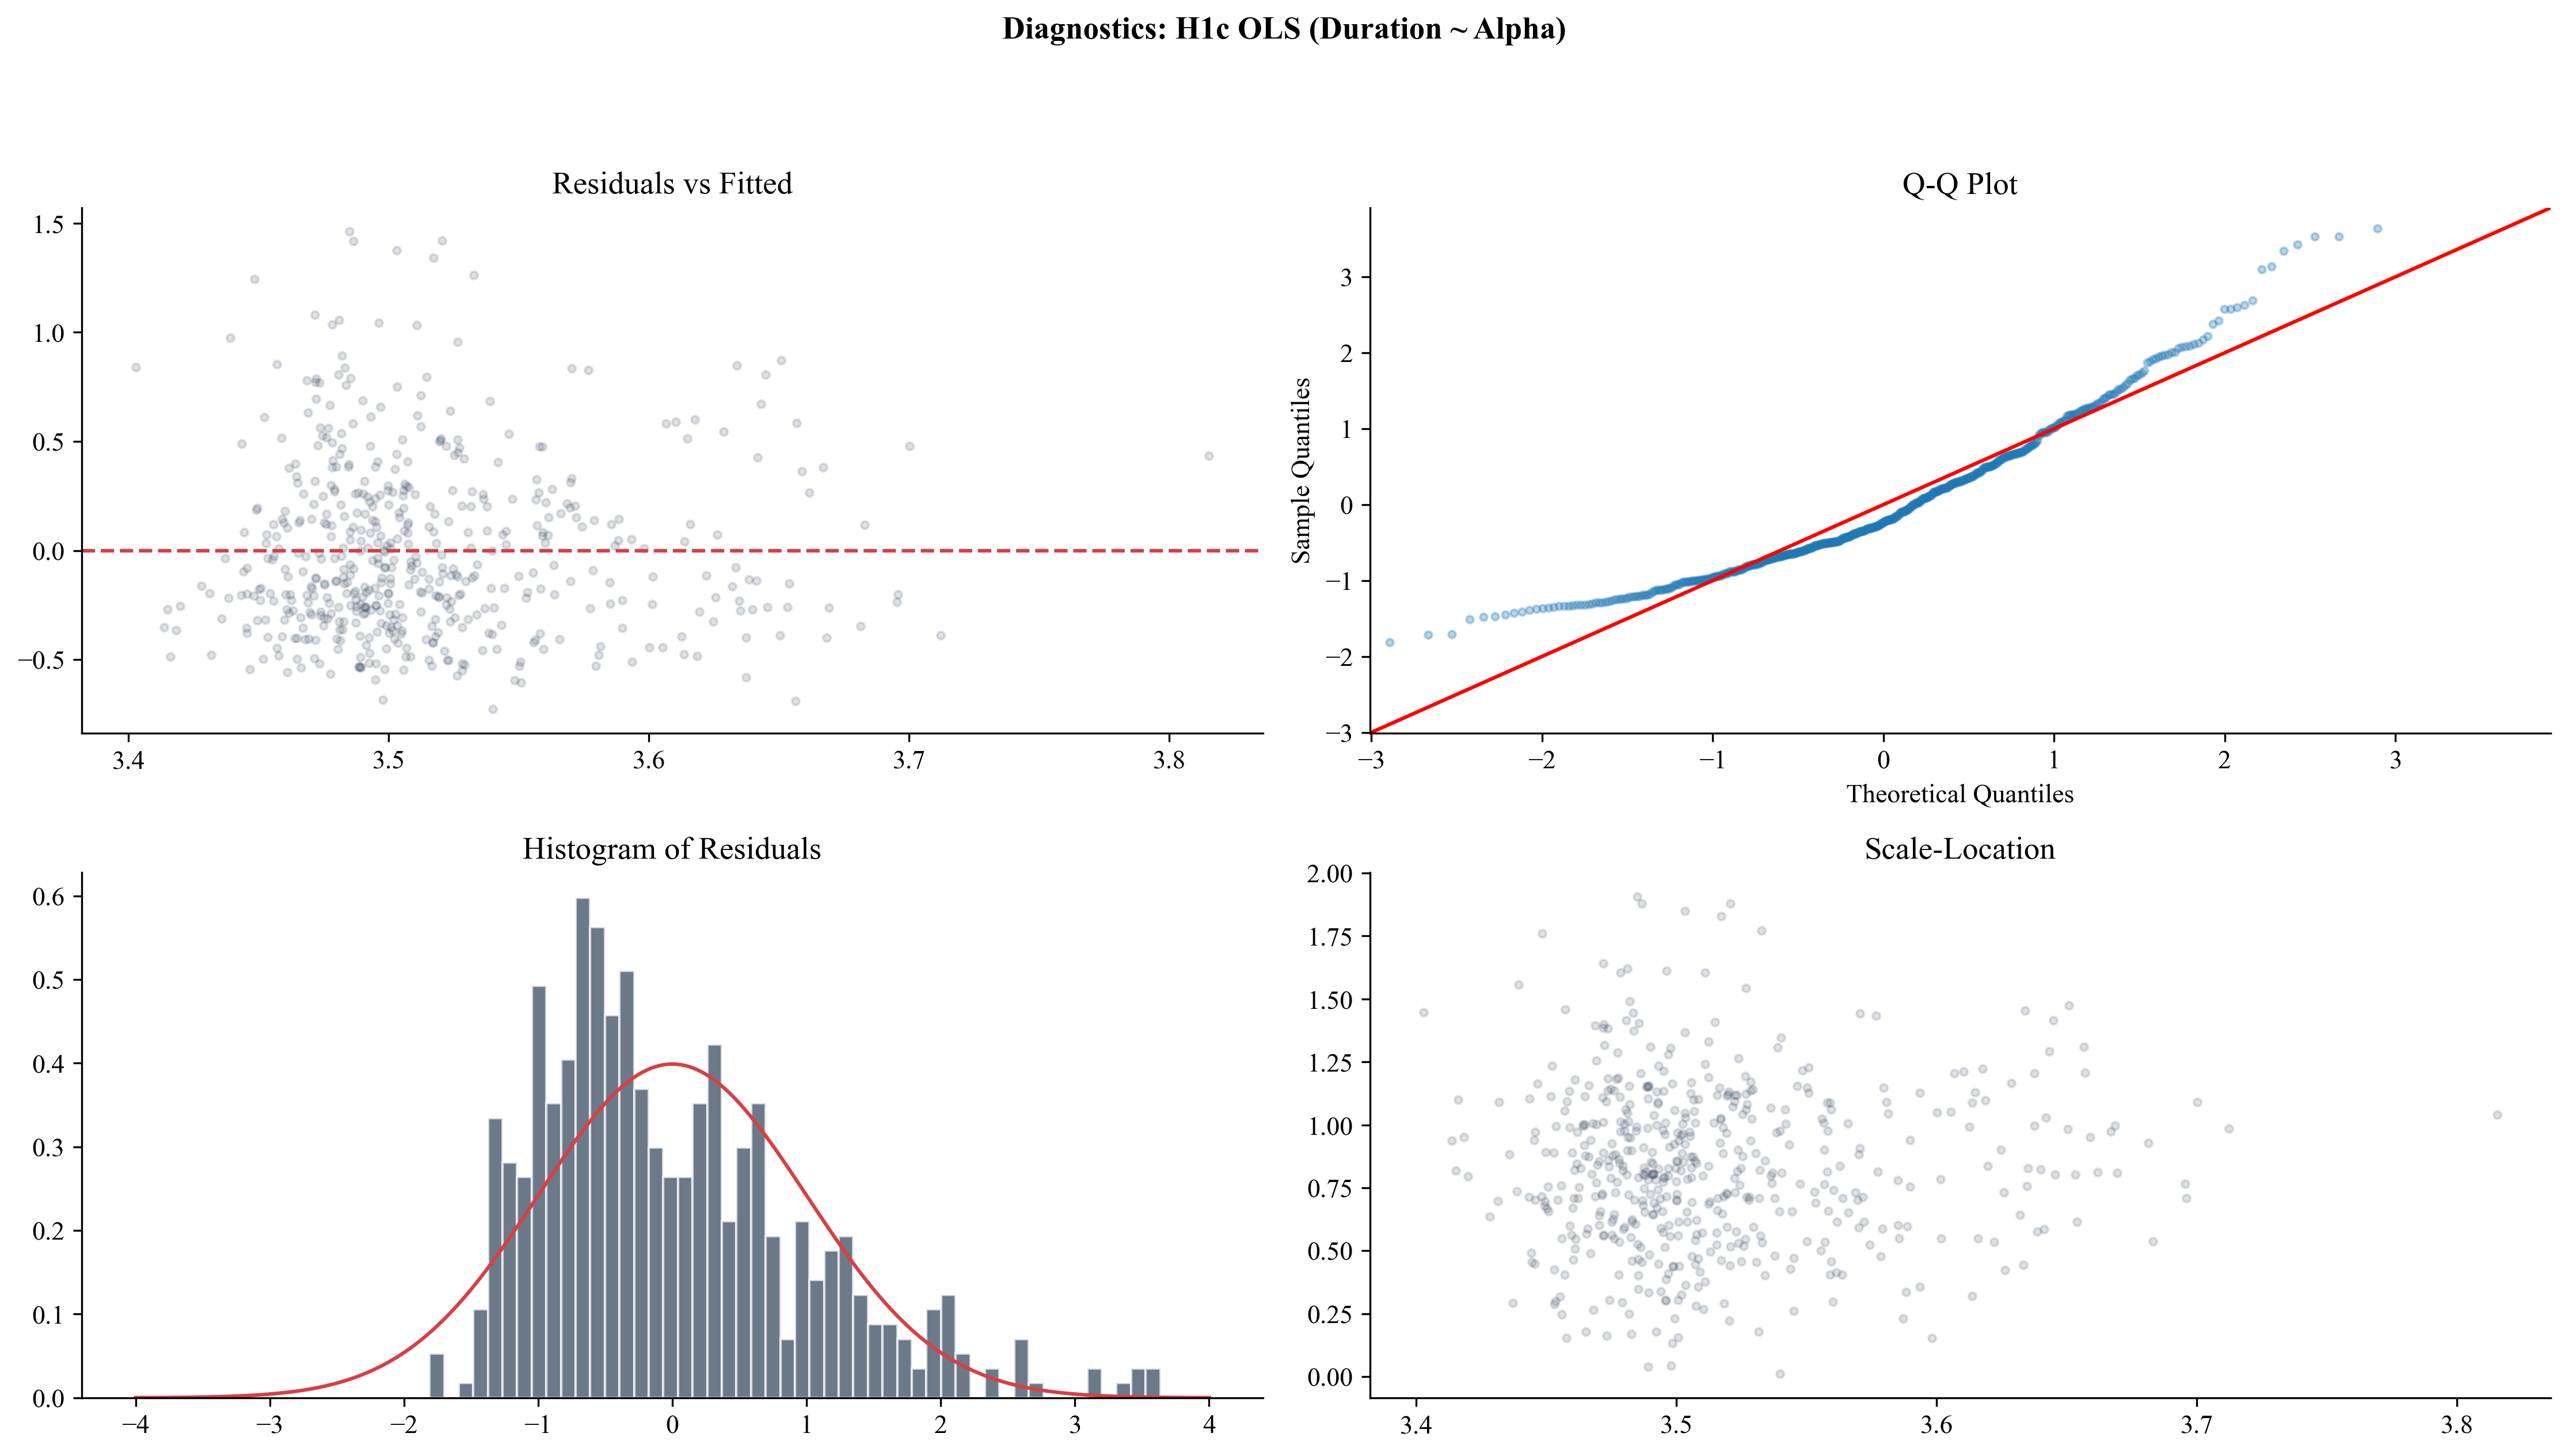


VIF - H1c OLS:
  ln_upper_alpha_frontal_mean: 1.00

VIF - H2a/H2c OLS (with interaction):
  n_ads_z: 1.00
  ad_position_c: 2.66
  n_ads_z:ad_position_c: 2.66

VIF - H2b/H2d OLS:
  n_ads_z: 1.00
  ad_position_c: 1.00


In [26]:
# H1c: OLS (Alpha → Duration) + VIF 
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Diagnostics: H1c OLS (Duration ~ Alpha)", fontweight="bold", y=1.05)

resid = m_dur.resid
fitted = m_dur.fittedvalues
std_resid = (resid - resid.mean()) / resid.std()

axes[0,0].scatter(fitted, resid, alpha=0.15, s=10, color=C_ACCENT)
axes[0,0].axhline(0, color=C_AD, ls="--")
axes[0,0].set_title("Residuals vs Fitted")

sm.qqplot(std_resid, line="45", ax=axes[0,1], markersize=3, alpha=0.3)
axes[0,1].set_title("Q-Q Plot")

axes[1,0].hist(std_resid, bins=50, color=C_ACCENT, alpha=0.7, edgecolor="white", density=True)
axes[1,0].plot(x_norm, stats.norm.pdf(x_norm), color=C_AD)
axes[1,0].set_title("Histogram of Residuals")

axes[1,1].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.15, s=10, color=C_ACCENT)
axes[1,1].set_title("Scale-Location")

for ax in axes.flat: ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Diag_H1c.png", bbox_inches="tight")
plt.show()

# VIF for H1c
print("\nVIF - H1c OLS:")
for i, name in enumerate(m_dur.model.exog_names):
    if name != "Intercept":
        print(f"  {name}: {variance_inflation_factor(m_dur.model.exog, i):.2f}")

# OLS Robustness Checks: VIF tables
print("\nVIF - H2a/H2c OLS (with interaction):")
for i, name in enumerate(M3.model.exog_names):
    if name != "Intercept":
        print(f"  {name}: {variance_inflation_factor(M3.model.exog, i):.2f}")

print("\nVIF - H2b/H2d OLS:")
for i, name in enumerate(m_ols.model.exog_names):
    if name != "Intercept":
        print(f"  {name}: {variance_inflation_factor(m_ols.model.exog, i):.2f}")

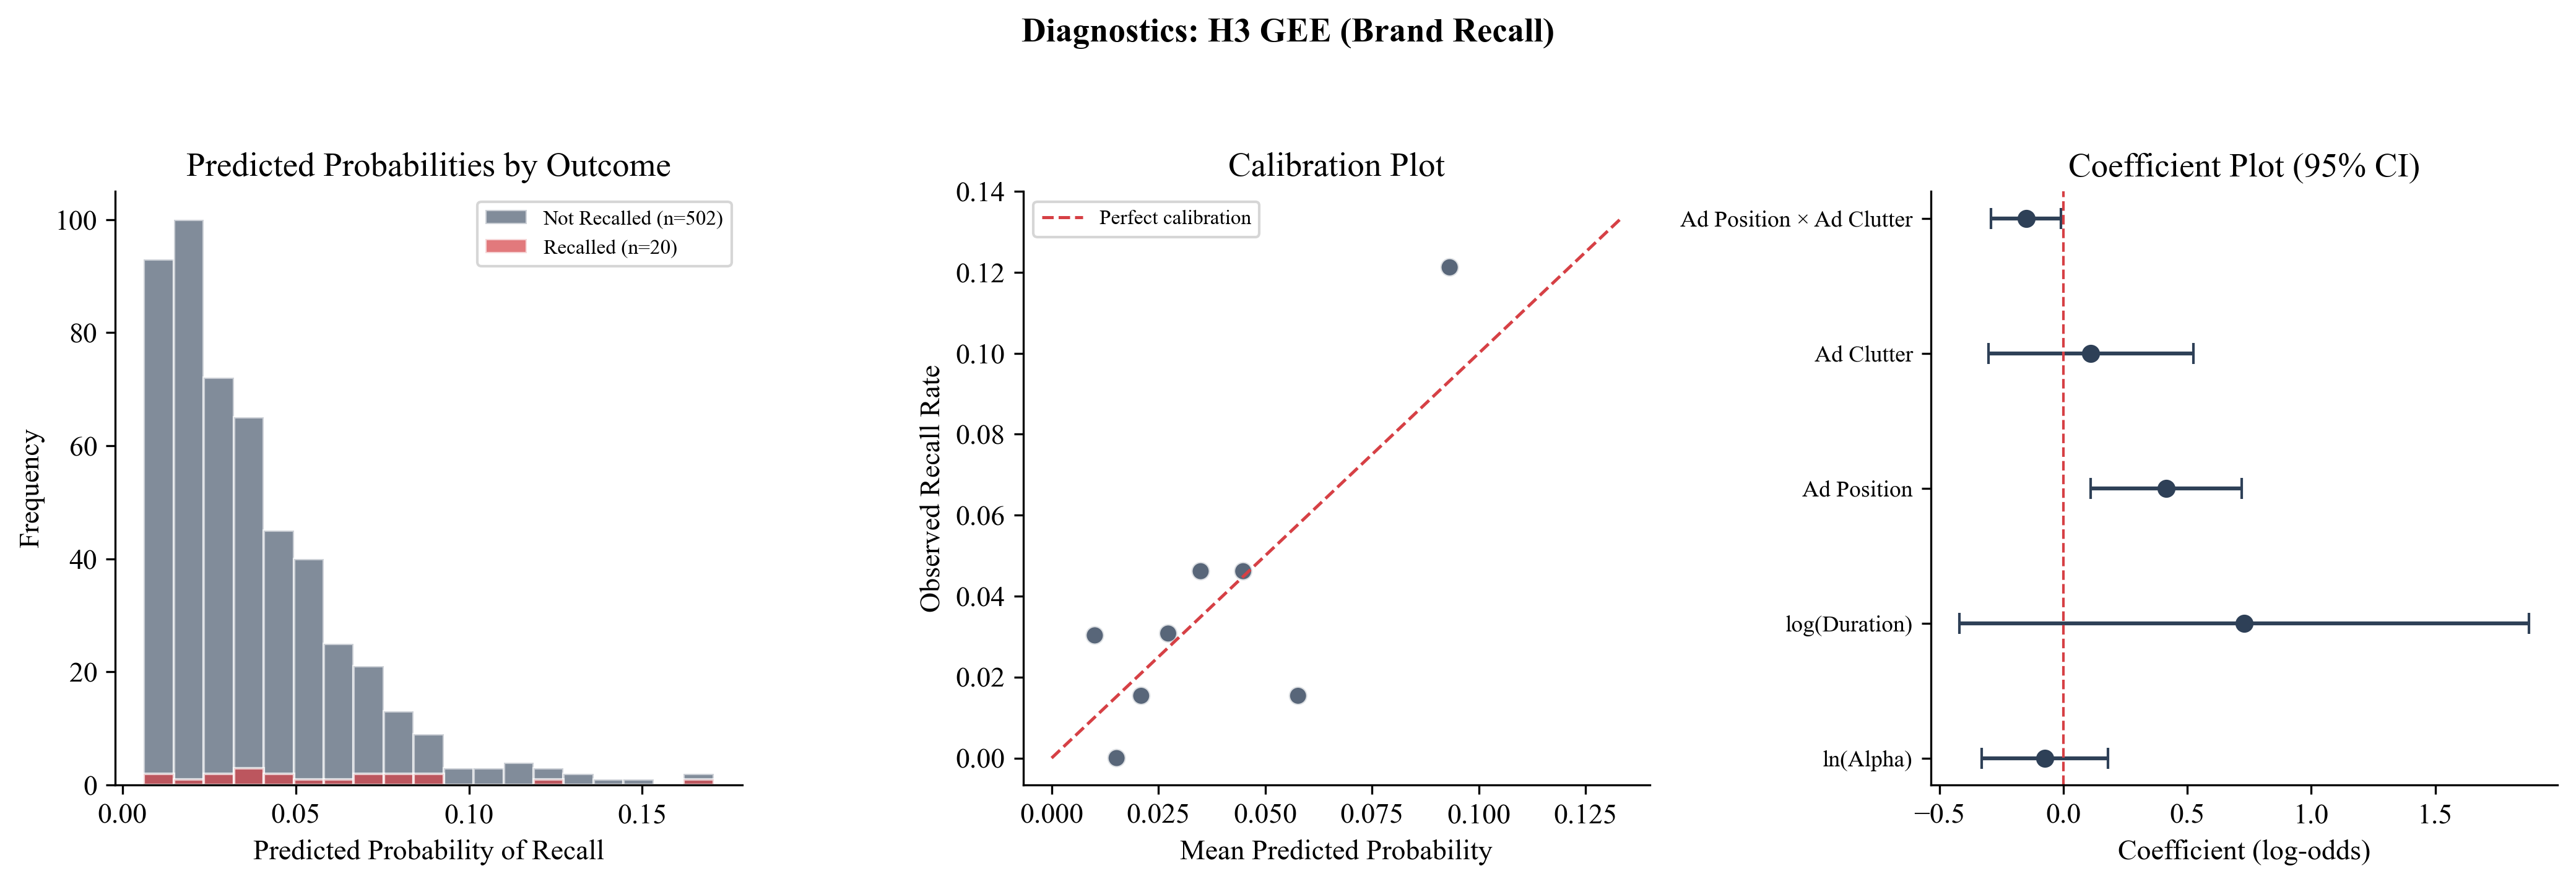

In [27]:
# H3: GEE Diagnostics (Binomial) 
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
fig.suptitle("Diagnostics: H3 GEE (Brand Recall)", fontweight="bold", y=1.05)

fitted_prob = gee.fittedvalues
y_actual = gee.model.endog

# 1. Predicted probability distributions by outcome (overlapping, same bins)
bins = np.linspace(fitted_prob.min(), fitted_prob.max(), 20)
axes[0].hist(fitted_prob[y_actual == 0], bins=bins, alpha=0.6, color=C_ACCENT,
             label=f"Not Recalled (n={int((y_actual==0).sum())})", edgecolor="white")
axes[0].hist(fitted_prob[y_actual == 1], bins=bins, alpha=0.7, color=C_AD,
             label=f"Recalled (n={int((y_actual==1).sum())})", edgecolor="white")
axes[0].set_xlabel("Predicted Probability of Recall")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Predicted Probabilities by Outcome")
axes[0].legend(fontsize=8)

# 2. Binned calibration plot (observed vs predicted)
df_cal = pd.DataFrame({"pred": fitted_prob, "actual": y_actual})
df_cal["bin"] = pd.qcut(df_cal["pred"], q=8, duplicates="drop")
cal = df_cal.groupby("bin", observed=True).agg(
    mean_pred=("pred", "mean"),
    mean_actual=("actual", "mean"),
    n=("actual", "size")
).reset_index()

axes[1].scatter(cal["mean_pred"], cal["mean_actual"], s=cal["n"]*0.8, color=C_ACCENT, alpha=0.8, edgecolor="white")
lim = max(cal["mean_pred"].max(), cal["mean_actual"].max()) * 1.1
axes[1].plot([0, lim], [0, lim], color=C_AD, ls="--", lw=1.2, label="Perfect calibration")
axes[1].set_xlabel("Mean Predicted Probability")
axes[1].set_ylabel("Observed Recall Rate")
axes[1].set_title("Calibration Plot")
axes[1].legend(fontsize=8)

# 3. Coefficient plot with 95% CI
params = gee.params.drop("Intercept")
conf = gee.conf_int().drop("Intercept")
y_pos = range(len(params))

axes[2].errorbar(params.values, y_pos,
                 xerr=[params.values - conf.iloc[:, 0].values,
                       conf.iloc[:, 1].values - params.values],
                 fmt="o", color=C_ACCENT, capsize=4, markersize=6)
axes[2].axvline(0, color=C_AD, ls="--", lw=1)
axes[2].set_yticks(list(y_pos))
short_names = [n.replace("ln_upper_alpha_frontal_mean", "ln(Alpha)")
                .replace("log_duration", "log(Duration)")
                .replace("ad_position_c", "Ad Position")
                .replace("n_ads_z", "Ad Clutter")
                .replace(":", " × ")
               for n in params.index]
axes[2].set_yticklabels(short_names, fontsize=9)
axes[2].set_xlabel("Coefficient (log-odds)")
axes[2].set_title("Coefficient Plot (95% CI)")

for ax in axes: ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("Diag_H3_GEE.png", bbox_inches="tight")
plt.show()